In [1]:
import pandas
import os
import itertools
import numpy as np
import nibabel as ni
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from glob import glob
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import model_selection, linear_model
from sklearn import mixture
from nilearn import image, plotting
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def PCA_LR_pipeline(in_mtx, y, pca = PCA(random_state=123), 
                    clf = linear_model.LassoCV(random_state = 123), 
                    cv_strategy = None, cv = 10, test_gene_num = [100], illustrative = False,
                   sanity_check_style = 'separate', cv_labels = []):
    
    final_outputs = {}
    
    if type(in_mtx) == pandas.core.frame.DataFrame:
        in_mtx = in_mtx.values
    
    if type(pca) == type(None):
        pca_tfm = in_mtx
    else:
        print('running PCA')
        dat_pca = pca.fit(in_mtx)
        print('transforming data')
        pca_tfm = dat_pca.transform(in_mtx)
        if len(y) != pca_tfm.shape[-1]:
            raise ValueError('length of y-axis of transformed item must match the length of y')
        final_outputs.update({'pca_object': dat_pca})
    
    
    print('performing model cross-validation')
    if hasattr(cv_strategy, 'get_n_splits'):
        folds = cv_strategy.get_n_splits(pca_tfm)
        #scores = model_selection.cross_val_score(clf, pca_tfm, y=y, groups=folds, cv=cv)
        predicted = model_selection.cross_val_predict(clf, pca_tfm, y=y, groups=folds, cv=cv)
        observed = y
        score = stats.pearsonr(predicted, y)[0]**2
    elif cv_strategy == 'LOLO':
        print('using leave-one-label-out cross-validation')
        observed, predicted = leave_one_x_out(cv_labels, pca_tfm, y, clf)
        score = stats.pearsonr(predicted,observed)[0]**2
    elif cv_strategy == 'balanced':
        print('balancing cross-validation by labels')
        observed, predicted = balanced_cv(cv_labels, pca_tfm, y, clf, cv)
        score = stats.pearsonr(predicted,observed)[0]**2
    elif type(cv_strategy) != type(None):
        print('using basic cross-validation')
        #scores = model_selection.cross_val_score(clf, pca_tfm, y=y, cv=cv)
        predicted = model_selection.cross_val_predict(clf, pca_tfm, y=y, cv=cv)
        observed = y
        score = stats.pearsonr(predicted, y)[0]**2
    else:
        score = None
    if type(score) != type(None):
        if illustrative:
            plt.close()
            sns.regplot(predicted, observed, fit_reg=False)
            plt.xlabel('CV model predicted position along axis')
            plt.ylabel('Actual position along axis')
            plt.show()
        print('model cv score: r2 = ',score)
        final_outputs.update({'CV_scores': score})
    else:
        print('no valid cross-validation method specified')
    
    print('running final model')
    mod = clf.fit(pca_tfm, y)
    if not hasattr(mod,'coef_'):
        raise IOError('right now, this pipeline can only accept clf objects with a coef_ attribute')
    final_outputs.update({'final_model': mod})
    scr = mod.score(pca_tfm, y)
    print('final model fit r2 = ',scr)
    if illustrative:
        plt.close()
        sns.regplot(x=mod.predict(pca_tfm), y=y)
        plt.xlabel('Model predicted position along A-P axis')
        plt.ylabel('Actual position along A-P axis')
        plt.show()
    
    if type(pca) == type(None):
        f_betas = mod.coef_
    else:
        f_betas = back_transform(dat_pca, mod)
    final_outputs.update({'betas': f_betas})
    
    gene_selections = sanity_check(in_mtx, y, f_betas, test_gene_num, 
                                   illustrative, sanity_check_style)
    final_outputs.update({'gene_selections': gene_selections})
    
    return final_outputs
    
def back_transform(pca_obj, clf_obj):
    return np.dot(pca_obj.components_.T,clf_obj.coef_)

def sanity_check(in_mtx, y, betas, test_gene_num, illustrative, sanity_check_style):
    
    if sanity_check_style == 'separate':
        ascores = []
        pscores = []
    else:
        scores = []
    print('running sanity_check')
    betas = pandas.Series(betas)
    outputs = {}
    for num in test_gene_num:
      
        p_chk = betas.sort_values(ascending=False)[:num].index
        a_chk = betas.sort_values(ascending=False)[-num:].index

        pchk_vals = []
        achk_vals = []
        
        for sample in range(in_mtx.shape[0]):
            to_avg = []
            for gene in p_chk:
                to_avg.append(in_mtx[sample,gene])
            pchk_vals.append(np.mean(to_avg))
        
        for sample in range(in_mtx.shape[0]):
            to_avg = []
            for gene in a_chk:
                to_avg.append(in_mtx[sample,gene])
            if sanity_check_style == 'separate':
                achk_vals.append(np.mean(to_avg))
            else:
                achk_vals.append(np.mean(to_avg) * -1)

        if sanity_check_style != 'separate':
            chk_vals = np.array(pchk_vals) + np.array(achk_vals)
            
        if sanity_check_style == 'separate':
            pr,pp = stats.pearsonr(pchk_vals, y)
            if illustrative:
                plt.close()
                sns.regplot(x=np.array(pchk_vals), y=y, fit_reg=None)
                plt.xlabel('expression of posterior direction genes')
                plt.ylabel('location along hippocampus (posterior = higher)')
                plt.show()
            print('posterior %s genes vs. y:  r2 = %s, p = %s \n\n'%(num, pr**2, pp))

            ar,ap = stats.pearsonr(achk_vals, y)
            if illustrative:
                plt.close()
                sns.regplot(x=np.array(achk_vals), y=y, fit_reg=None)
                plt.xlabel('expression of anterior direction genes')
                plt.ylabel('location along hippocampus (posterior = higher)')
                plt.show()
            print('anterior %s genes vs. y:  r2 = %s, p = %s \n\n'%(num, ar**2, ap))
            
        else:
            r,p = stats.pearsonr(chk_vals, y)
            if illustrative:
                plt.close()
                sns.regplot(x=np.array(chk_vals), y=y, fit_reg=None)
                plt.xlabel('expression of A-P axis genes')
                plt.ylabel('location along hippocampus (posterior = higher)')
                plt.show()
            print('posterior %s genes vs. y:  r2 = %s, p = %s \n\n'%(num, r**2, p))
            
        if sanity_check_style == 'separate':
            ascores.append(ar**2)
            pscores.append(pr**2)
        else:
            scores.append(r**2)
        outputs.update({'posterior_genes_%s'%num: p_chk}) 
        outputs.update({'anterior_genes_%s'%num: a_chk})
            
    if len(test_gene_num) > 1:
        if sanity_check_style == 'separate':
            jnk = pandas.concat([pandas.Series(test_gene_num), 
                                 pandas.Series(ascores),
                                pandas.Series(pscores)],axis=1)
            jnk.columns = ['num','a','p']

            plt.close()
            fig,(ax1,ax2) = plt.subplots(2, figsize=(8,10))
            sns.factorplot(x='num', y='a', data=jnk, ax=ax1)
            sns.factorplot(x='num', y='p', data=jnk, ax=ax2)
            ax1.set(xlabel = 'Number of posterior genes', 
                    ylabel ='Explained variance in \nhippocampus a-p gradient')
            ax2.set(xlabel = 'Number of anterior genes', 
                    ylabel ='Explained variance in \nhippocampus a-p gradient')
            plt.show()
        else:
            jnk = pandas.concat([pandas.Series(test_gene_num), 
                                 pandas.Series(scores)
                                ],axis=1)
            jnk.columns = ['num','score']

            plt.close()
            fig,ax1 = plt.subplots(1, figsize=(8,10))
            sns.factorplot(x='num', y='score', data=jnk, ax=ax1)
            ax1.set(xlabel = 'Number of genes', 
                    ylabel ='Explained variance in \nhippocampus a-p gradient')
            plt.show()

    return outputs

def leave_one_x_out(labels, in_X, in_y, clf):

    obsz = []
    predz = []
    label_map = dict(zip(labels.unique(), range(len(labels.unique()))))
    labels = [label_map[x] for x in labels]
    for label in np.unique(labels):
        Tr_samps = [i for i in labels if labels[i] != label]
        Te_samps = [i for i in labels if labels[i] == label]
        X = in_X[Tr_samps,:]
        in_y = y.iloc[Tr_samps]
        mod = clf.fit(X,y)
        pred = mod.predict(in_X[Te_samps,:])
        for x in range(len(pred)):
            obsz.append(y.values[x])
            predz.append(pred[x])
    
    return obsz, predz

def balanced_cv(labels, in_X, in_y, clf, cv):
    
    obsz = []
    predz = []
    tst = model_selection.StratifiedKFold(n_splits=cv, random_state=123)
    label_map = dict(zip(labels.unique(), range(len(labels.unique()))))
    labels = [label_map[x] for x in labels]
    for tr_idx, te_idx in tst.split(in_X, labels):
        X = in_X[tr_idx,:]
        y = in_y.loc[tr_idx]
        mod = clf.fit(X,y)
        pred = mod.predict(in_X[te_idx,:])
        for i in range(len(predz)):
            obsz.append(y.values[x])
            predz.append(pred[i])
            
    return obsz, predz

In [3]:
def convert_coords(coord, to_what = 'mni', vs = 1):
    origin = [90, 126, 72]
    origin = (np.array(origin) / vs).astype(int).tolist()
    x,y,z = coord[0],coord[1],coord[2]
    
    if to_what == 'mni':
        x = (origin[0]-x)*vs
        y = (y-origin[1])*vs
        z = (z-origin[2])*vs
        
    elif to_what == 'xyz':
        x=origin[0]- x/vs
        y=y/vs + origin[1]
        z=z/vs + origin[2]
        
    else:
        raise IOError('please set to_what to either mni or xyz')
    
    return x,y,z

In [4]:
def make_sphere(coord, radius):
    summers = []
    negrad = (radius*-1)+1
    for x in itertools.product(range(negrad,radius),repeat=3):
        summers.append(np.array(x))
    s_coords = [np.array(coord) + x for x in summers]
    xs = [int(x[0]) for x in s_coords]
    ys = [int(x[1]) for x in s_coords]
    zs = [int(x[2]) for x in s_coords]
    
    return xs, ys, zs

In [5]:
def run_hipp_connectivity_analysis(ant_cut, post_cut, df, ycol, 
                                   ccol, wdir, gdf, msk, gcx_col, plabs,
                                   del_img = True, diff_img = True,  vrad = 5,
                                  in_imgs = [], bootstrap = False, hue_vals=[]):
    
    if len(in_imgs) == 0:
        a_idx = df.loc[[x for x in df.index if df.loc[x,ycol] < ant_cut]].index
        p_idx = df.loc[[x for x in df.index if df.loc[x,ycol] > post_cut]].index
        print('%s maps used for posterior, %s used for anterior'%(len(p_idx),len(a_idx)))
        print('\n')
        print('processing anterior image')
        aimg = make_mean_img(df.loc[a_idx,ccol].tolist(),wdir,del_img, 'ant')
        print('processing posterior image')
        pimg = make_mean_img(df.loc[p_idx,ccol].tolist(),wdir,del_img,'post')
    
        if diff_img:
            print('running analysis')
            diff_img = aimg - pimg
            run_gvfcx_analysis(diff_img, gdf, msk, vrad, gcx_col, plabs, bootstrap, hue_vals)
        else:
            print('running posterior analysis')
            run_gvfcx_analysis(pimg, gdf, msk, vrad, gcx_col, plabs, bootstrap, hue_vals)
            print('running anterior analysis')
            run_gvfcx_analysis(aimg, gdf, msk, vrad, gcx_col, plabs, bootstrap, hue_vals)
    else:
        if diff_img:
            diff_img = ni.load(in_imgs[0]).get_data() - ni.load(in_imgs[1]).get_data()
            run_gvfcx_analysis(diff_img, gdf, msk, vrad, gcx_col, plabs, bootstrap, hue_vals)
        else:
            for img in in_imgs:
                print('running analysis for image',img)
                dat = ni.load(img).get_data()
                run_gvfcx_analysis(dat, gdf, msk, vrad, gcx_col, plabs, bootstrap, hue_vals)
    
def make_mean_img(scans, wdir, del_img, lab):
    
    print('making mean image')
    img = ni.concat_images(scans)
    x,y,z,q,t = img.shape
    mat = img.get_data().reshape(x,y,z,t)
    mimg = ni.Nifti1Image(mat.mean(axis=3),img.affine)
    fnm = os.path.join(wdir,'del_%s_img.nii'%lab)
    mimg.to_filename(fnm)
    
    print('moving to template space')
    #mni = '/Users/jakevogel/Science/tau/MNI152_T1_1mm_brain.nii'
    mni = '/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii'
    #tfm = '/Users/jakevogel/Science/AHBA/cx_maps/2_to_1_mm_tfm'
    tfm = '/home/users/jvogel/Science/templates/tfms/2_to_1mm_MNI.tfm'
    nfnm = os.path.join(wdir,'%s_img.nii'%lab)
    #os.system('flirt -in %s -ref %s -applyxfm -init %s -out %s'%(fnm,mni,tfm,nfnm))
    os.system('fsl5.0-flirt -in %s -ref %s -applyxfm -init %s -out %s'%(fnm,mni,tfm,nfnm))
    os.remove(fnm)
    nfnm = nfnm+'.gz'
    fimg = ni.load(nfnm).get_data()
    if del_img:
        os.remove(nfnm)
    
    return fimg

def run_gvfcx_analysis(img, gdf, msk, vrad, gcx_col, plabs, bootstrap, hue_vals):
    g_cx = []
    f_cx = []
    if len(hue_vals) > 0:
        hvs = []
    
    for i,row in gdf.iterrows():
        #coord = convert_coords([row['mni_x'], row['mni_y'], row['mni_z']], 'xyz')
        coord = convert_coords([row['mni_nlin_x'], row['mni_nlin_y'], row['mni_nlin_z']], 'xyz')
        coord = [round(x) for x in coord]
        if msk[coord[0],coord[1],coord[2]] != 0:
            xs,ys,zs = make_sphere(coord, vrad)
            val = img[xs,ys,zs]
            f_cx.append(val.mean())
            g_cx.append(row[gcx_col])
            if len(hue_vals) > 0:
                hvs.append(hue_vals[i])
    
    if len(hue_vals) == 0:
        plt.close()
        sns.regplot(np.array(g_cx), np.array(f_cx))
        plt.title(plabs[0])
        plt.xlabel(plabs[1])
        plt.ylabel(plabs[2])
        plt.show()
    else:
        jnk = pandas.DataFrame(index=range(len(g_cx)),columns = plabs[1:])
        jnk.loc[:,plabs[1]] = g_cx
        jnk.loc[:,plabs[2]] = f_cx
        jnk.loc[:,'sample expression cluster'] = hvs
        sns.lmplot(x=plabs[1],y=plabs[2],hue='sample expression cluster',data=jnk)
        plt.show()

    r, p = stats.pearsonr(np.array(g_cx), np.array(f_cx))
    print('standard statistics: r2 = %s, p = %s'%(r**2,p))
    
    if bootstrap == 'permute':
        distr = []
        for i in range(1000):
            distr.append(stats.pearsonr(np.random.permutation(np.array(g_cx)),
                                        np.array(f_cx)
                                       )[0]**2)
        distr = np.array(distr)
        p = (1000 - len(distr[distr<r**2])) * 0.001
        print('permuted p-value = ',p)
    
    elif bootstrap == 'bootstrap':
        # NEED TO MAKE THIS FASTER SO I CAN DO IT AT LEAST 100 TIMES.
        # AS OF NOW, IT TAKES LIKE >15 seconds to run 1
        r_cx = []
        possible_coords = np.where(msk!=0)
        rand_coords = np.random.permutation(range(len(possible_coords[0])))[:len(g_cx)]
        for i in rand_coords:
            rand_coord = [possible_coords[0][i], 
                          possible_coords[1][i], 
                          possible_coords[2][i]]
            xs,ys,zs = make_sphere(coord, vrad)
            r_cx.append(img[xs,ys,zs].mean())
        r, p = stats.pearsonr(np.array(g_cx), np.array(r_cx))
        print('random chance association: r2 = %s, p = %s'%(r**2,p))


In [6]:
def make_expression_image(vector, coords, projection_space, 
                          wdir = './', nm = 'gene', vrad=5,
                         return_img = False):
    if len(vector) != len(coords):
        print('input and coordinate vectors must have the same length')
    if type(projection_space) == str:
        jnk = ni.load(projection_space)
        aff = jnk.affine
        dat = jnk.get_data()
    else:
        try:
            aff = projection_space.affine
            dat = projection_space.get_data()
        except:
            raise IOError('projection_space must be a NiftiImage object or path to .nii file')
    nimg = np.zeros_like(dat).astype(float)
    for i in range(len(vector)):
        xs,ys,zs = make_sphere(coords[i], vrad)
        nimg[xs,ys,zs] = vector[i]
    nimg = ni.Nifti1Image(nimg,aff)
    flnm = os.path.join(wdir,'%s_xp_image.nii.gz'%nm)
    nimg.to_filename(flnm)
    
    if return_img:
        return nimg

In [7]:
def find_closest_point_along_axis(coords,skel_coords):
    closest_coords = []
    y_coord = []
    for coord in sample_coords:
        dists = []
        for i in range(len(skel_coords[0])):
            dist = sum([abs(skel_coords[0][i] - coord[0]), 
                        abs(skel_coords[1][i] - coord[1]), 
                        abs(skel_coords[2][i] - coord[2])])
            dists.append(dist)
        gind = np.argmin(dists)
        closest_coords.append([skel_coords[0][gind],
                               skel_coords[1][gind],
                                skel_coords[2][gind]])
        y_coord.append(skel_coords[1][gind])

    return y_coord, closest_coords

In [8]:
def get_gene_vector(bigdf, gene_vec = [], probe_ids = []):
    
    if len(gene_vec) == 0 and len(probe_ids) == 0:
        raise IOError('please supply either a gene vector or probe IDs')
    if len(gene_vec) > 0 and len(probe_ids) > 0:
        raise IOError('please supply either a gene vector or probe IDs, but NOT BOTH!')\
    
    if len(gene_vec) > 0:
        gene_vec = np.array(gene_vec)
        vals = []
        for i in range(bigdf.shape[-1]):
            try:
                vals.append(stats.pearsonr(gene_vec,
                                        bigdf.loc[:,bigdf.columns[i]])[0])
            except:
                bigdf.columns = ['col_%s'%x for x in range(bigdf.shape[-1])]
                vals.append(stats.pearsonr(gene_vec,
                                        bigdf.loc[:,bigdf.columns[i]])[0])
    
    elif len(probe_ids) > 0:
        vals = bigdf.loc[probe_ids].mean().values
        
    return vals
    

In [9]:
def label_coordinate_by_atlas(atlas, coordinates, cube_size = 1):
    ''' This function will take a set of coordinates and an atlas and return the
    atlas label for each coordinate. Optionally, a cube can be drawn around the 
    coordinate. In this case, the most frequent non-zero value inside the cube will 
    be selected as the label. The function will output a pandas dataframe with a
    label for each input coordinate.
    
    atlas can be a path to a nifti image, or a nifti object, or a 3D np.ndarray
    
    coordinates can be a pandas Dataframe, a numpy.ndarray or a list of lists, 
    representing the mni coordinates for each input corrdinate. as such, the 
    length of one of the dimensions should be 3
    
    cube_size represents the radius of the cube to be created. leaving it as 1 will
    only retrieve the value at the coordinate specified. Increasing the value will 
    draw a cube of increasing size and collect values from within the cube. The most
    frequent non-zero value within the cube will be selected
    
    '''
    
    # initiate and check inputs
    atl, coords = init_and_chk_inputs(atlas,coordinates)
    
    # convert coordinates to xyz space
    xyz = np.array([convert_coords(coords[x],'xyz') for x in range(coords.shape[0])
                   ]).astype(int)
    
    # create output container
    results = pandas.DataFrame(index=range(coords.shape[0]),columns = ['Label'])
    
    # get labels for each coordinate
    print('extracting labels')
    if cube_size == 1:
        results.loc[:,'Label'] = atl[xyz[:,0].tolist(),xyz[:,1].tolist(),xyz[:,2].tolist()]
    else:
        labs = []
        for i in range(xyz.shape[0]):
            labs.append(extract_value_from_cube(xyz[i,:], cube_size, atl))
        results.loc[:,'Label'] = labs
    
    print('completed')
    print('%s coordinates were outside of the provided atlas'%(
                                            len(results[results.Label==0])))

    return results
    
def init_and_chk_inputs(atlas,coordinates):
    print('checking and initializing inputs')
    if type(atlas) == str:
        atl = ni.load(atlas).get_data()
    elif type(atlas) == ni.nifti1.Nifti1Image: 
        atl = atlas.get_data()
    elif type(atlas) == np.core.memmap.memmap or type(atlas) == np.ndarray:
        atl = atlas
    else:
        raise IOError('atlas must be a nifti object, a numpy array or a path to a nifti file')
    
    if type(coordinates) == pandas.core.frame.DataFrame:
        coords = coordinates.values
       
    elif type(coordinates) == list or type(coordinates) == tuple:
        if len(coordinates)== 3:
            coords = np.zeros((len(coordinates[0]),3))
            for i in range(3):
                coords[:,i] = coords[i]
    elif type(coordinates) == np.ndarray:
        coords = coordinates
    else:
        raise IOError('coordiantes must be a pandas dataframe, numpy array or list of lists')
    
    if not any(x==3 for x in coords.shape):
        raise IOError('Coordinates are 3D and thus 3 columns are expected...')
    elif coords.shape[-1] != 3:
        coords = coords.T
    
    coords = coords.round()
    
    return atl,coords
    
def convert_coords(coord, to_what = 'mni', vs = 1):
    origin = [90, 126, 72]
    origin = (np.array(origin) / vs).astype(int).tolist()
    x,y,z = coord[0],coord[1],coord[2]
    
    if to_what == 'mni':
        x = (origin[0]-x)*vs
        y = (y-origin[1])*vs
        z = (z-origin[2])*vs
        
    elif to_what == 'xyz':
        x=origin[0]- x/vs
        y=y/vs + origin[1]
        z=z/vs + origin[2]
        
    else:
        raise IOError('please set to_what to either mni or xyz')
    
    return x,y,z

def extract_value_from_cube(coord, radius, atl):
    
    xs,ys,zs = make_cube(coord, radius)
    cube_vals = atl[xs,ys,zs]
    if stats.mode(cube_vals)[0][0] == 0:
        if len(cube_vals[cube_vals!=0]) > 0:
            lab = stats.mode(cube_vals[cube_vals!=0])[0][0]
        else:
            lab = 0
    else:
        lab = stats.mode(cube_vals)[0][0]
    
    return lab
        
def make_cube(coord, radius):
    summers = []
    negrad = (radius*-1)+1
    for x in itertools.product(range(negrad,radius),repeat=3):
        summers.append(np.array(x))
    s_coords = [np.array(coord) + x for x in summers]
    xs = [int(x[0]) for x in s_coords]
    ys = [int(x[1]) for x in s_coords]
    zs = [int(x[2]) for x in s_coords]
    
    return xs, ys, zs

# Get hippocampus samples

In [10]:
wdir = '/data1/users/jvogel/Allen_Human_Brain_Atlas/'
df = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_sample_info.csv'))
xp = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_gxp.csv'),index_col=0)
gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info.csv'))
probes = pandas.read_csv(os.path.join(wdir,'normalized_microarray_donor9861/Probes.csv'))

In [10]:
# PERSONAL COMPUTER
wdir = '/Users/jakevogel/Science/AHBA/'
df = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_sample_info.csv'))
xp = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_gxp.csv'),index_col=0)
gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info.csv'))
probes = pandas.read_csv('/Users/jakevogel/Downloads/normalized_microarray_donor9861/Probes.csv')

FileNotFoundError: File b'/Users/jakevogel/Science/AHBA/MAIN_hippocampus_sample_info.csv' does not exist

In [10]:
hipp_labs = [x for x in gdf.structure_name.unique() if 'CA' in x or 'dentate gyrus' in x or 'subiculum' in x]
hipp_samps = [x for x in gdf.index if gdf.loc[x,'structure_name'] in hipp_labs]
len(hipp_samps)

188

In [11]:
gdf.columns[-3:]

Index(['mni_nlin_x', 'mni_nlin_y', 'mni_nlin_z'], dtype='object')

In [18]:
vec = np.ones(len(hipp_samps))
input_coords = []
for i,row in gdf.loc[hipp_samps].iterrows():
    input_coords.append(convert_coords([row['mni_nlin_x'], row['mni_nlin_y'], row['mni_nlin_z']], 'xyz'))
mni = ni.load('/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii')
nm = 'binary_hippocampus_sample'
hsamp_img = make_expression_image(vec, input_coords, mni, wdir, nm, 2, return_img=True)

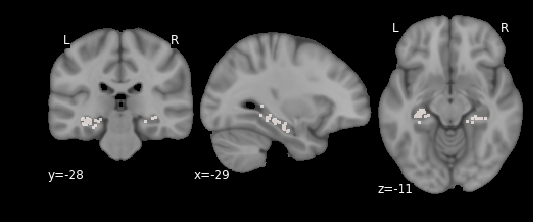

In [19]:
plt.close()
plotting.plot_roi(hsamp_img, mni, draw_cross=False, cmap='Reds')
plt.show()

In [24]:
[x for x in range(len(gdf.columns)) if 'mni' in gdf.columns[x]]

[13, 14, 15, 28, 29, 30]

In [27]:
# Figure out how many sample coordinates are outside of the hippocampus mask (by an unreasonable margin)
hipp_mask = ni.load('/home/users/jvogel/Science/templates/masks/Hippocampus_maxprob_thr0_1mm.nii')
lin_inside = label_coordinate_by_atlas(hipp_mask, gdf.loc[hipp_samps,gdf.columns[13:16]], cube_size = 3)
nlin_inside = label_coordinate_by_atlas(hipp_mask, gdf.loc[hipp_samps,gdf.columns[-3:]], cube_size = 3) 

checking and initializing inputs
extracting labels
completed
27 coordinates were outside of the provided atlas
checking and initializing inputs
extracting labels
completed
18 coordinates were outside of the provided atlas


In [39]:
# updating hipp_samps to remove the 18 samples that are too far out
hipp_samps = gdf.loc[hipp_samps].index[nlin_inside[nlin_inside.Label==1].index]

In [99]:
df = gdf.loc[hipp_samps]
df.shape

(170, 31)

In [78]:
#df.drop(df.columns[16:27],axis=1,inplace=True)
#df.columns

Index(['Unnamed: 0', 'donor', 'sample', 'structure_id', 'slab_num', 'well_id',
       'slab_type', 'structure_acronym', 'structure_name', 'polygon_id',
       'mri_voxel_x', 'mri_voxel_y', 'mri_voxel_z', 'mni_x', 'mni_y', 'mni_z',
       'gabe_label', 'mni_nlin_x', 'mni_nlin_y', 'mni_nlin_z',
       'position_along_hipp_AP_axis'],
      dtype='object')

In [79]:
df.to_csv(os.path.join(wdir,'MAIN_hippocampus_sample_info.csv'),index=False)

In [44]:
# GET GENE EXPRESSION FOR HIPPOCAMPAL SAMPLES 
# (loading this df takes awhile and may not work on computers without lots of memory (its about 60k x 4k))
wdir = '/data1/users/jvogel/Allen_Human_Brain_Atlas/'
shtz = sorted(glob(os.path.join(wdir,'normalized_microarray_donor*/MExp_all_genes_ctr_for_donor')))
holder = []
for sht in shtz:
    holder.append(pandas.read_csv(sht,index_col=0))
bigdf = pandas.concat(holder,axis=1)
del(holder)
ncols = ['%s_%s'%(gdf.loc[x,'donor'],bigdf.columns[x]) for x in range(gdf.shape[0])]
bigdf.columns = ncols

In [56]:
xp = bigdf.loc[:,bigdf.columns[hipp_samps.astype(int)]]
xp.shape

(58692, 170)

In [66]:
xp.to_csv(os.path.join(wdir,'MAIN_hippocampus_gxp.csv'))

This whole section is me cross-checking with my old data to be sure i'm indexing properly

In [67]:
old_xp = pandas.read_csv(os.path.join(wdir,'whole_hippocampus_xp_allsubs_cleaned_labeled.csv'))

In [59]:
#CHECK OLD DATA TO MAKE SURE EVERYTHING IS CORRECT
old_df = pandas.read_csv(os.path.join(
        wdir,'whole_hippocampus_hit_coordinates_cleaned_all_c_labs.csv'))
old_df = old_df.loc[[x for x in old_df.index if pandas.notnull(old_df.loc[x,'2_c_solution'])]]

In [112]:
old_id = []
for i,row in old_df.iterrows():
    old_id.append(df[(df.donor==row['sub']) & (df['sample']==row['label']+1)].index[0])

In [102]:
df.loc[:,'basic_idx'] = range(df.shape[0])

In [103]:
match_df = df.loc[old_id]
match_df.head()

,Unnamed: 0,donor,sample,structure_id,slab_num,well_id,slab_type,structure_acronym,structure_name,polygon_id,...,mixed_test_p20_avg_gene_expression,p20_LARS_avg_gene_expression,p20_SPCR_avg_gene_expression,p500_SPCR_avg_gene_expression,p50_SPCR_avg_gene_expression,gabe_label,mni_nlin_x,mni_nlin_y,mni_nlin_z,basic_idx
524,524,10021,525,4258,13,5905,CX,DG,"dentate gyrus, left",1027911,...,-0.770956,-0.461315,-1.193483,-0.491563,-0.596289,H0351.2002,-30.060635,-17.008006,-17.804403,5
525,525,10021,526,4257,13,5897,CX,CA4,"CA4 field, left",1029991,...,-0.474285,-0.288329,-0.637411,-0.038679,-0.508617,H0351.2002,-28.809634,-17.152891,-17.827365,6
527,527,10021,528,4254,13,5881,CX,CA1,"CA1 field, left",1027902,...,-0.682998,-0.233764,-1.059782,-0.086003,-0.713043,H0351.2002,-33.634115,-15.568971,-20.362231,8
528,528,10021,529,4251,13,5873,CX,S,"subiculum, left",1027901,...,-0.366067,-0.434494,-0.339502,-0.066769,-0.151106,H0351.2002,-23.591102,-15.565700,-23.657211,9
531,531,10021,532,4258,15,5828,CX,DG,"dentate gyrus, left",1013074,...,0.312757,0.214687,0.225555,0.422113,0.109198,H0351.2002,-28.284228,-34.642097,-7.793446,10


In [107]:
match_xp = xp.iloc[:,match_df.basic_idx]

In [111]:
for i in range(match_xp.shape[-1]):
    print(stats.pearsonr(match_xp.values[:,i],old_xp.values[:-6,i]))

(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(0.99999999999999978, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0,

ok we're good

# Get location of samples along axis

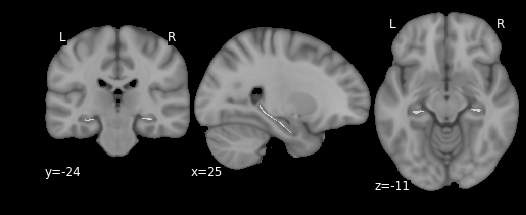

In [63]:
ap_axis = ni.load('/data1/users/jvogel/Allen_Human_Brain_Atlas/axis/blob_line_skel_1mm_2nii.nii')
mni = ni.load('/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii')
plt.close()
plotting.plot_roi(ap_axis, mni, draw_cross=False, cmap='Reds')
plt.show()

In [64]:
sample_coords = []
for i,row in df.iterrows():
    sample_coords.append(convert_coords([row['mni_nlin_x'], row['mni_nlin_y'], row['mni_nlin_z']], 'xyz'))
skel_coords = np.where(ap_axis.get_data() > 0)
y_location, closest_points = find_closest_point_along_axis(sample_coords,skel_coords)

In [67]:
df.loc[:,'position_along_hipp_AP_axis'] = y_location

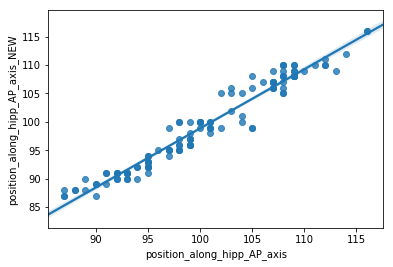

In [117]:
# how has it changed since after getting the correct (non-linear) coordinates?
match_df = df.loc[old_id]
plt.close()
sns.regplot(match_df.position_along_hipp_AP_axis, old_df.position_along_hipp_AP_axis_NEW)
plt.show()

# Run main analysis pipeline and evaluate

In [184]:
pcalr_out_NEW2 = PCA_LR_pipeline(xp.values.T, 
                            (df.position_along_hipp_AP_axis), 
                            cv_strategy='balanced', illustrative=True,
                           test_gene_num = [1, 2, 5, 10, 20, 50, 100, 
                                            200, 500, 1000, 2000, 5000],
                               sanity_check_style = 'separate', cv_labels = df.structure_acronym)

running PCA
transforming data
performing model cross-validation
balancing cross-validation by labels


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:3016: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:3017: RuntimeWarning: Mean of empty slice.
  my = y.mean()
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


TypeError: only integer scalar arrays can be converted to a scalar index

running PCA
transforming data
performing model cross-validation
using basic cross-validation


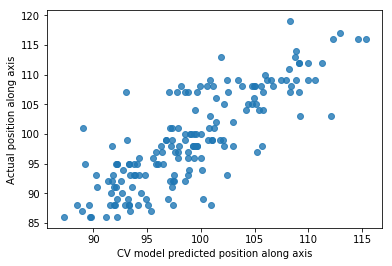

model cv score: r2 =  0.675885977482
running final model
final model fit r2 =  0.876810509326


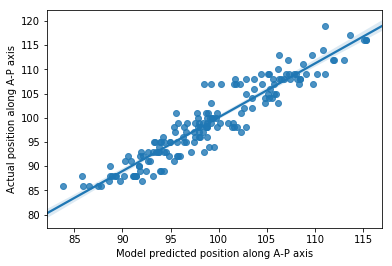

running sanity_check


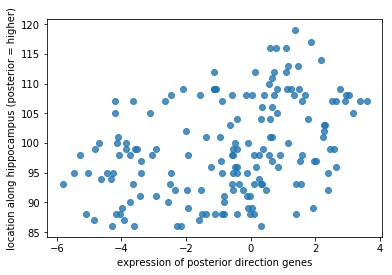

posterior 1 genes vs. y:  r2 = 0.146291960145, p = 2.64362300167e-07 




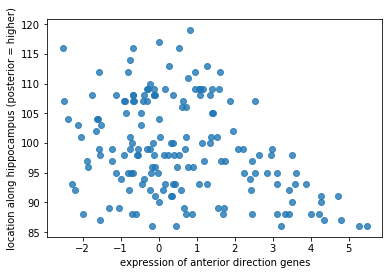

anterior 1 genes vs. y:  r2 = 0.120839023188, p = 3.40674823134e-06 




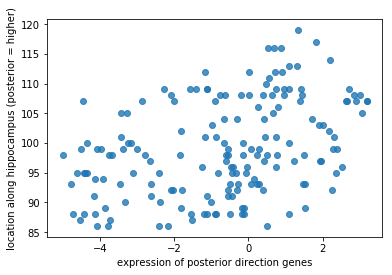

posterior 2 genes vs. y:  r2 = 0.156810463199, p = 9.03376115525e-08 




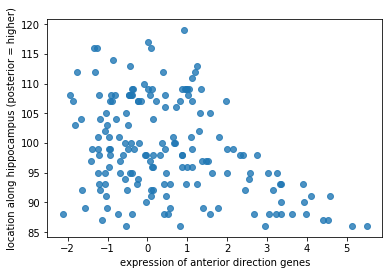

anterior 2 genes vs. y:  r2 = 0.140782455333, p = 4.61980605763e-07 




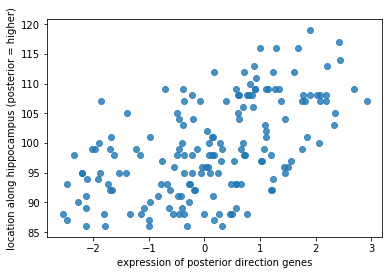

posterior 5 genes vs. y:  r2 = 0.312027641285, p = 2.46628262071e-15 




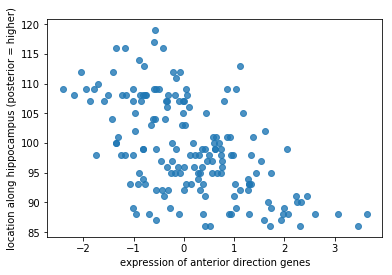

anterior 5 genes vs. y:  r2 = 0.308872084395, p = 3.6401288821e-15 




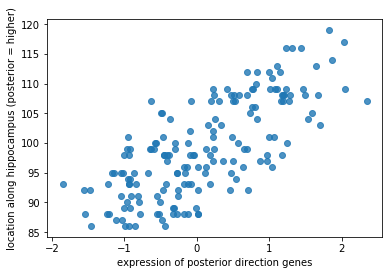

posterior 10 genes vs. y:  r2 = 0.541743338152, p = 2.83625582234e-30 




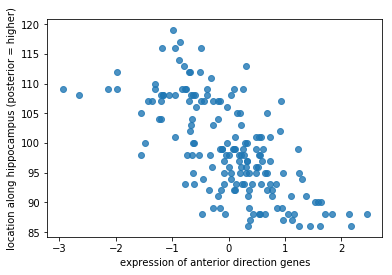

anterior 10 genes vs. y:  r2 = 0.45513306654, p = 6.38206163432e-24 




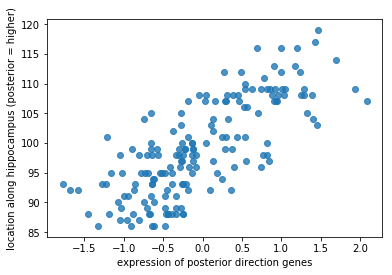

posterior 20 genes vs. y:  r2 = 0.577277974194, p = 3.12395740458e-33 




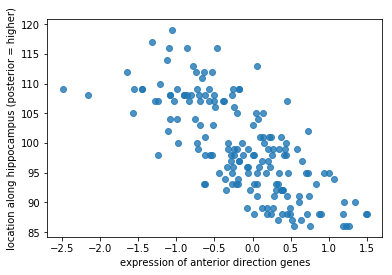

anterior 20 genes vs. y:  r2 = 0.528759540293, p = 3.00011527119e-29 




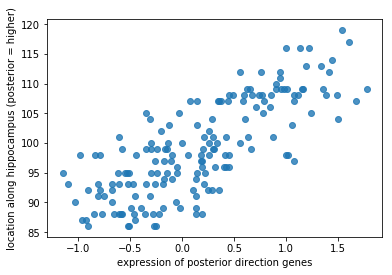

posterior 50 genes vs. y:  r2 = 0.604781566638, p = 1.07277863382e-35 




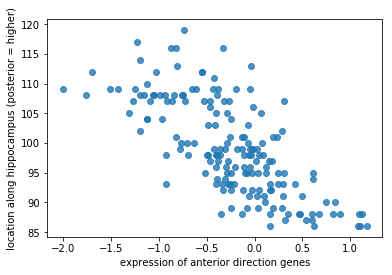

anterior 50 genes vs. y:  r2 = 0.521495808996, p = 1.09169856187e-28 




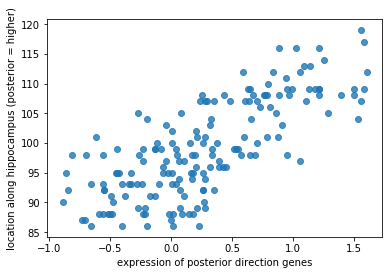

posterior 100 genes vs. y:  r2 = 0.568535370196, p = 1.75686862748e-32 




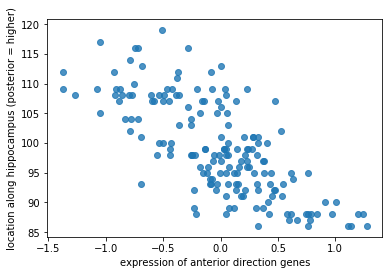

anterior 100 genes vs. y:  r2 = 0.530569444547, p = 2.16785299609e-29 




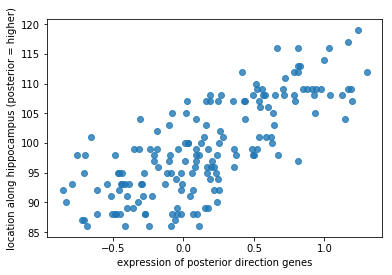

posterior 200 genes vs. y:  r2 = 0.573989954195, p = 6.00589222139e-33 




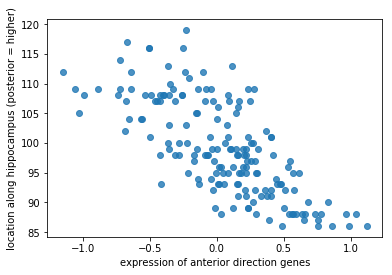

anterior 200 genes vs. y:  r2 = 0.530012749169, p = 2.396015094e-29 




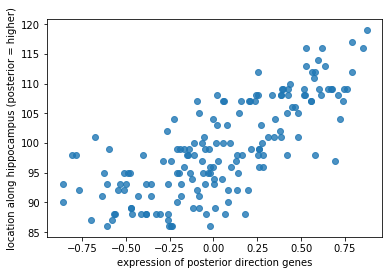

posterior 500 genes vs. y:  r2 = 0.561315373964, p = 7.1262999131e-32 




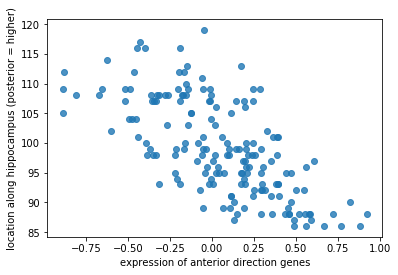

anterior 500 genes vs. y:  r2 = 0.456701046713, p = 5.00149396762e-24 




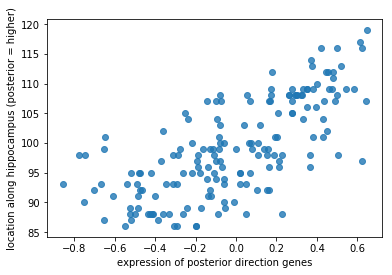

posterior 1000 genes vs. y:  r2 = 0.506219222541, p = 1.5519698984e-27 




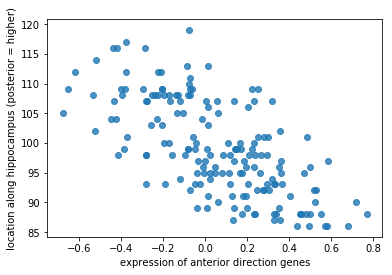

anterior 1000 genes vs. y:  r2 = 0.454418293527, p = 7.13048262374e-24 




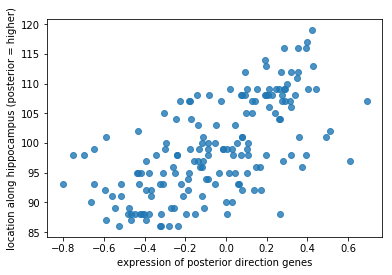

posterior 2000 genes vs. y:  r2 = 0.413582900724, p = 3.20747873988e-21 




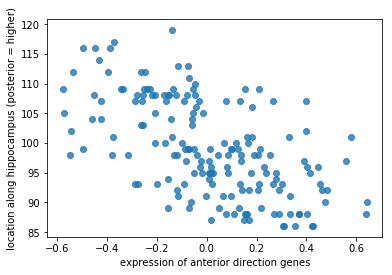

anterior 2000 genes vs. y:  r2 = 0.348659261806, p = 2.35874690133e-17 




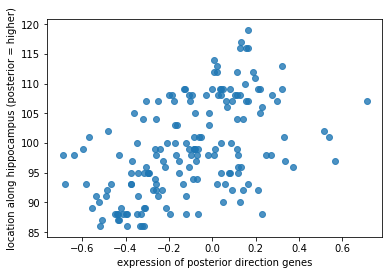

posterior 5000 genes vs. y:  r2 = 0.260250683548, p = 1.19416253845e-12 




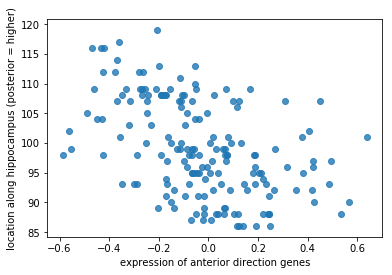

anterior 5000 genes vs. y:  r2 = 0.227039856261, p = 5.09894187119e-11 




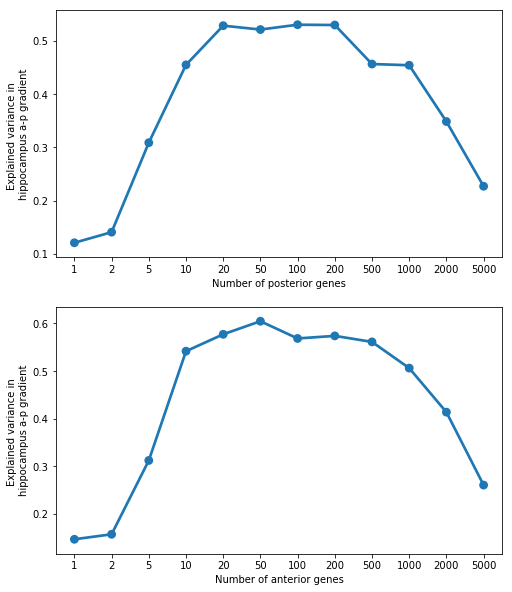

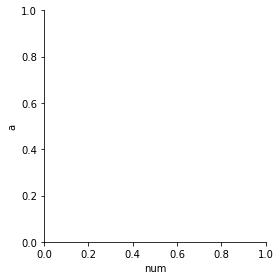

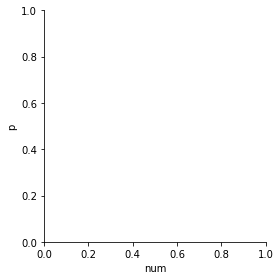

In [105]:
pcalr_out_NEW = PCA_LR_pipeline(xp.values.T, 
                            (df.position_along_hipp_AP_axis), 
                            cv_strategy='score', illustrative=True,
                           test_gene_num = [1, 2, 5, 10, 20, 50, 100, 
                                            200, 500, 1000, 2000, 5000],
                               sanity_check_style = 'separate')

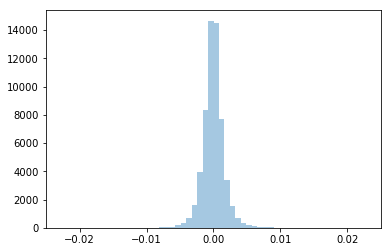

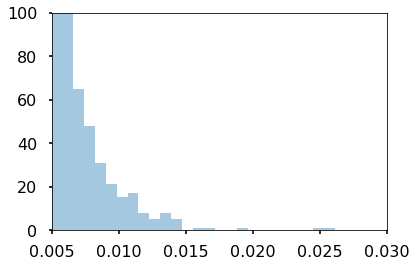

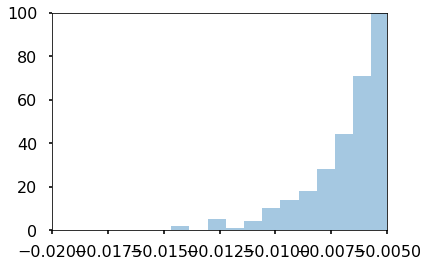

In [14]:
plt.close()
sns.distplot(pcalr_out_NEW['betas'],kde=False)
plt.xlim(-0.025,0.025)
plt.show()

sns.set_context('poster')
plt.close()
sns.distplot(pcalr_out_NEW['betas'],kde=False)
plt.xlim(0.005,0.030)
plt.ylim(0,100)
plt.show()

plt.close()
sns.distplot(pcalr_out_NEW['betas'],kde=False)
plt.xlim(-0.020,-0.005)
plt.ylim(0,100)
plt.show()

In [128]:
df.loc[:,'bilateral_structure_name'] = [x.split(',')[0] for x in df.structure_name.values]
df.bilateral_structure_name.head()

19        CA1 field
20        CA2 field
21        CA3 field
22        CA4 field
23    dentate gyrus
Name: bilateral_structure_name, dtype: object

In [137]:
df.loc[:,'bigdf_index'] = df.index
df.index = df.basic_idx

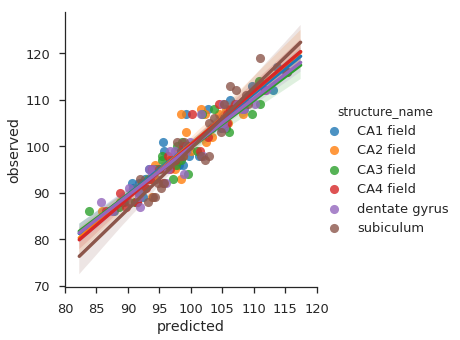

In [138]:
sns.set_context('talk')
sns.set_style('ticks')
pca_tfm = pcalr_out_NEW['pca_object'].transform(xp.values.T)
predicted = pcalr_out_NEW['final_model'].predict(pca_tfm)
jnk = pandas.concat([pandas.Series(predicted),
                     df.position_along_hipp_AP_axis,
                    df.bilateral_structure_name], axis=1)
jnk.columns = ['predicted','observed','structure_name']
plt.close()
sns.lmplot(x='predicted', y='observed', hue='structure_name', data=jnk)
plt.xticks(range(80,125,5))
plt.show()

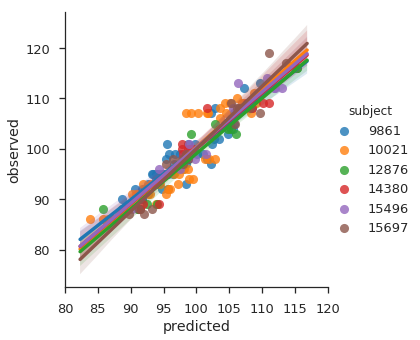

In [141]:
sns.set_context('talk')
sns.set_style('ticks')
pca_tfm = pcalr_out_NEW['pca_object'].transform(xp.values.T)
predicted = pcalr_out_NEW['final_model'].predict(pca_tfm)
jnk = pandas.concat([pandas.Series(predicted),
                     df.position_along_hipp_AP_axis,
                    df['donor']], axis=1)
jnk.columns = ['predicted','observed','subject']
plt.close()
sns.lmplot(x='predicted', y='observed', hue='subject', data=jnk)
plt.xticks(range(80,125,5))
plt.show()

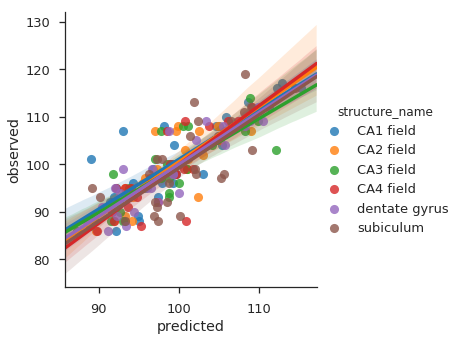

0.675885977482


In [142]:
predicted = model_selection.cross_val_predict(linear_model.LassoCV(random_state = 123), 
                                              pca_tfm, df.position_along_hipp_AP_axis, 
                                              cv=10)
jnk = pandas.concat([pandas.Series(predicted),
                     df.position_along_hipp_AP_axis,
                    df.bilateral_structure_name], axis=1)
jnk.columns = ['predicted','observed','structure_name']
plt.close()
sns.lmplot(x='predicted', y='observed', hue='structure_name', data=jnk)
plt.show()
print(stats.pearsonr(jnk.observed, jnk.predicted)[0]**2)

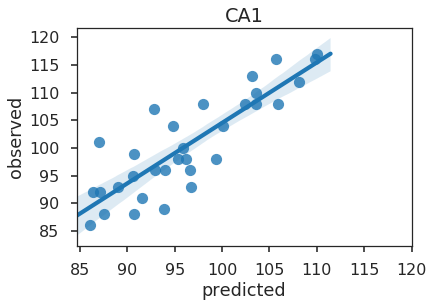

0.73682


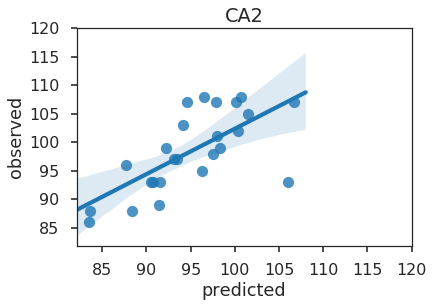

0.47144


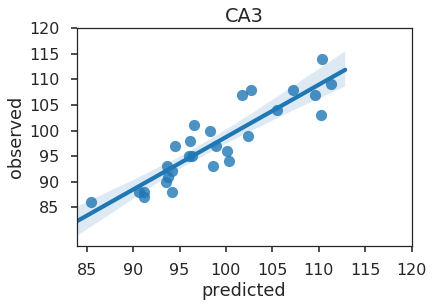

0.79736


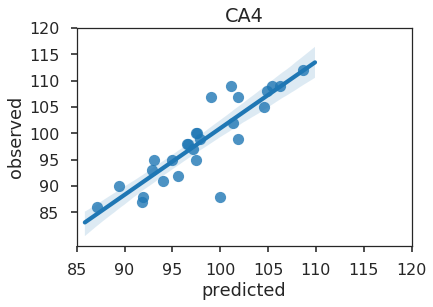

0.75732


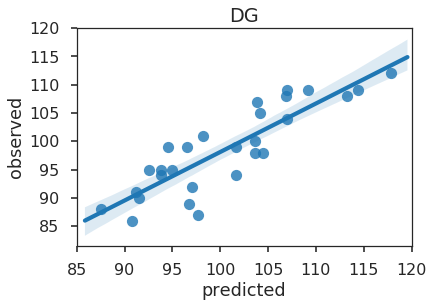

0.75098


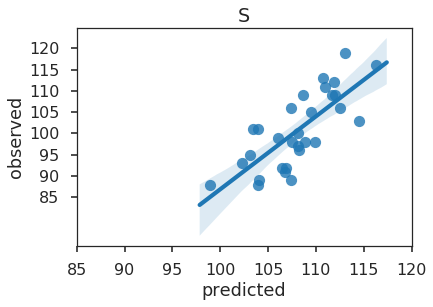

0.58105


In [159]:
# LEAVE-ONE-SUBFIELD-OUT
# LEAVE ONE SUBFIELD OUT

te_ids = []
predz = []
clf = linear_model.LassoCV(random_state = 123)
for subfield in df.structure_acronym.unique():
    Tr_samps = df[df.structure_acronym!=subfield].index
    Te_samps = df[df.structure_acronym==subfield].index
    X = pca_tfm[Tr_samps,:]
    y = df.loc[Tr_samps,'position_along_hipp_AP_axis']
    mod = clf.fit(X,y)
    pred = mod.predict(pca_tfm[Te_samps,:])
    
    plt.close()
    sns.set_context('poster')
    sns.regplot(pred, df.loc[Te_samps,'position_along_hipp_AP_axis'].values)
    plt.title(subfield)
    plt.xticks(range(85,125,5))
    plt.yticks(range(85,125,5))
    plt.xlabel('predicted')
    plt.ylabel('observed')
    plt.show()
    print(np.float16(stats.pearsonr(pred, df.loc[Te_samps,'position_along_hipp_AP_axis'].values)[0]**2))

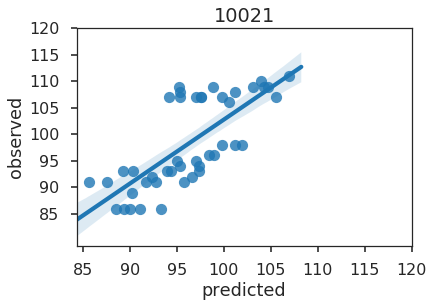

0.5498


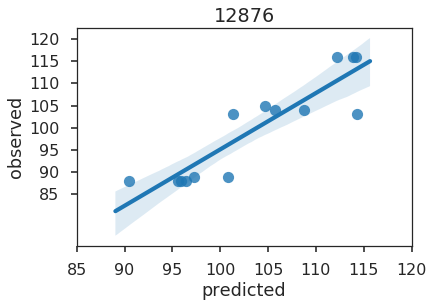

0.81348


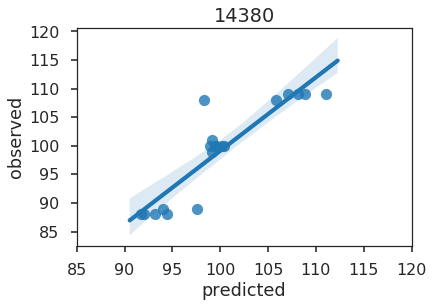

0.80566


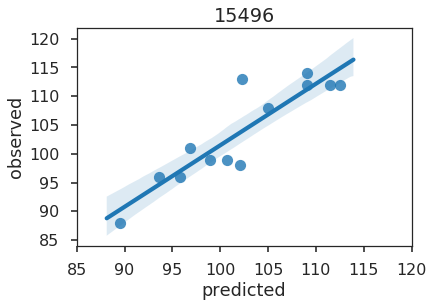

0.80908


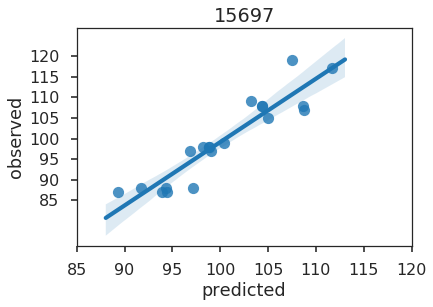

0.86768


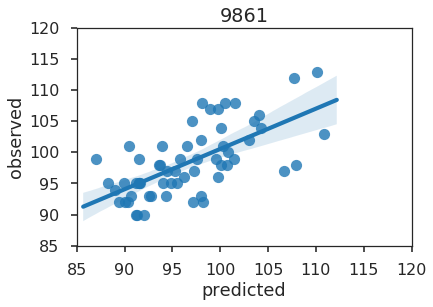

0.4353


In [157]:
# LEAVE ONE SUBJECT OUT

te_ids = []
predz = []
clf = linear_model.LassoCV(random_state = 123)
for subject in df['donor'].unique():
    Tr_samps =  df[df['donor']!=subject].index
    Te_samps = df[df['donor']==subject].index
    X = pca_tfm[Tr_samps,:]
    y = df.loc[Tr_samps,'position_along_hipp_AP_axis']
    mod = clf.fit(X,y)
    pred = mod.predict(pca_tfm[Te_samps,:])
    
    plt.close()
    sns.regplot(pred, df.loc[Te_samps,'position_along_hipp_AP_axis'].values)
    plt.title(subject)
    plt.xticks(range(85,125,5))
    plt.yticks(range(85,125,5))
    plt.xlabel('predicted')
    plt.ylabel('observed')
    plt.show()
    print(np.float16(stats.pearsonr(pred, df.loc[Te_samps,'position_along_hipp_AP_axis'].values)[0]**2))

performing model cross-validation
model cv score: r2 =  0.683122988007
running final model
final model fit r2 =  0.753654391585
running sanity_check
posterior 1 genes vs. y:  r2 = 0.446002455241, p = 2.6032211812e-23 


anterior 1 genes vs. y:  r2 = 0.24035463409, p = 1.15290738796e-11 


posterior 2 genes vs. y:  r2 = 0.515931868699, p = 2.89816535039e-28 


anterior 2 genes vs. y:  r2 = 0.239490920682, p = 1.27056182384e-11 


posterior 5 genes vs. y:  r2 = 0.605248194838, p = 9.71064668955e-36 


anterior 5 genes vs. y:  r2 = 0.321748266788, p = 7.35339558721e-16 


posterior 10 genes vs. y:  r2 = 0.604763385956, p = 1.07694779731e-35 


anterior 10 genes vs. y:  r2 = 0.396868361378, p = 3.46842986903e-20 


posterior 20 genes vs. y:  r2 = 0.378216940098, p = 4.58491169552e-19 


anterior 20 genes vs. y:  r2 = 0.308636594726, p = 3.74717949023e-15 


posterior 50 genes vs. y:  r2 = 0.0874754350363, p = 9.01085676934e-05 


anterior 50 genes vs. y:  r2 = 0.125292691065, p = 2.1869402

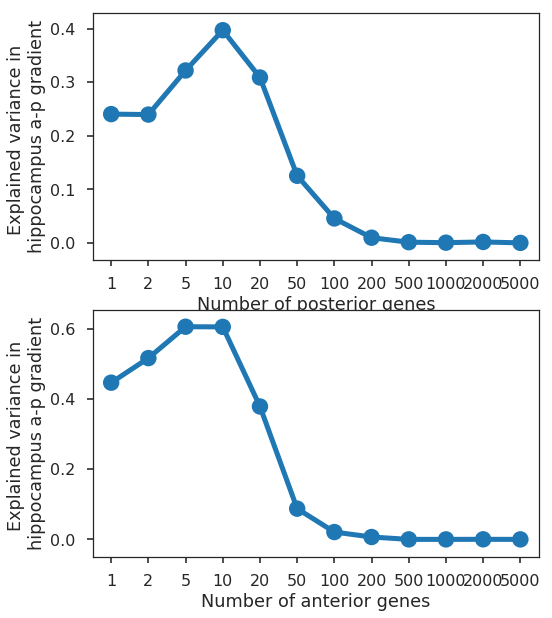

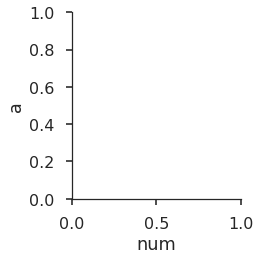

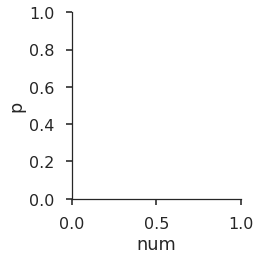

In [149]:
# JUST FOR THE FUCK OF IT, LETS TRY IT WITH LARS
pcalr_out_NEW_LARS = PCA_LR_pipeline(xp.values.T, 
                            (df.position_along_hipp_AP_axis),
                              pca=None, clf = linear_model.LassoLarsCV(),
                            cv_strategy='score', illustrative=False,
                           test_gene_num = [1, 2, 5, 10, 20, 50, 100, 
                                            200, 500, 1000, 2000, 5000] )

In [21]:
probes.loc[pcalr_out_NEW['gene_selections']['anterior_genes_50']]['gene_symbol'].tolist()[::-1]

['NPNT',
 'NPNT',
 'TTR',
 'A_32_P11262',
 'BDKRB1',
 'SERTAD4',
 'NTN1',
 'HHIP',
 'HHIP',
 'RP11-561O23.6',
 'GRHL2',
 'RGMA',
 'BDKRB1',
 'BNC2',
 'TPBG',
 'OSBPL3',
 'NTN1',
 'ONECUT2',
 'COL5A2',
 'RP11-291L15.2',
 'FSTL4',
 'C1orf133',
 'DGKI',
 'DDC',
 'A_24_P401842',
 'A_32_P121537',
 'TNNT2',
 'FSTL4',
 'TTR',
 'HPSE2',
 'DDC',
 'DDC',
 'COL5A2',
 'WNT10A',
 'CASR',
 'DDC',
 'PVALB',
 'A_24_P62668',
 'FAM43B',
 'CTXN3',
 'DDC',
 'HPSE2',
 'GAL',
 'GREM2',
 'KDELR3',
 'COL5A2',
 'PDLIM5',
 'ONECUT2',
 'A_24_P102119',
 'GAL']

In [20]:
probes.loc[pcalr_out_NEW['gene_selections']['posterior_genes_50']]['gene_symbol'].tolist()

['SERPINF1',
 'SERPINF1',
 'KLK7',
 'RSPH9',
 'KLK7',
 'LYPD1',
 'GABRQ',
 'PYDC1',
 'SYTL2',
 'RP13-102H20.1',
 'SYTL2',
 'SSTR1',
 'LXN',
 'TMEM215',
 'SYTL2',
 'C1QL1',
 'PIRT',
 'KCNG1',
 'AQP3',
 'A_23_P213527',
 'RP11-45B20.3',
 'C1orf187',
 'GPR39',
 'OPRK1',
 'CD36',
 'AQP3',
 'KLK7',
 'MYB',
 'GPR26',
 'LMO1',
 'GPR88',
 'VGLL3',
 'NR2F2',
 'NR2F2',
 'NR2F2',
 'GPR83',
 'GDA',
 'NRG1',
 'RSPO2',
 'A_32_P136776',
 'C20orf103',
 'SYTL1',
 'LGALS2',
 'LXN',
 'GPR26',
 'KIAA1772',
 'A_32_P115840',
 'GDA',
 'SEMA3D',
 'NRG1']

# Whole brain stuff

In [188]:
gcx_SPCR = get_gene_vector(bigdf, gene_vec=pcalr_out_NEW['betas'])

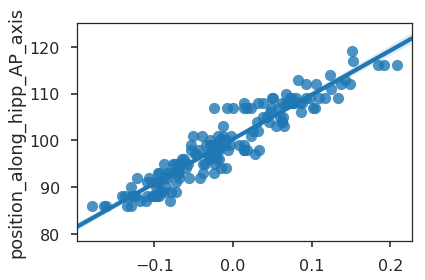

(0.9424780132848114, 7.2779027890333583e-82)


In [192]:
rs = []
for i,samp in enumerate(xp.columns):
    svec = xp[samp]
    refvec = pcalr_out_NEW['betas']
    r,p = stats.pearsonr(svec,refvec)
    rs.append(r)
plt.close()
sns.regplot(np.array(rs),df.position_along_hipp_AP_axis)
plt.show()
print(stats.pearsonr(np.array(rs),df.position_along_hipp_AP_axis))

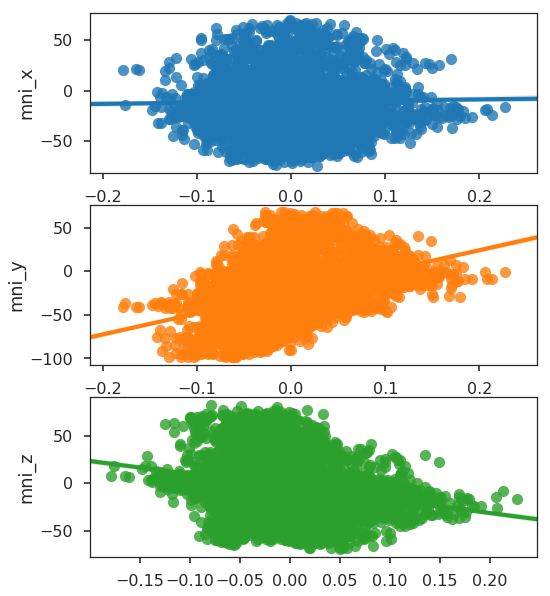

0.000534885864914
0.168072211755
0.0608717979577


In [193]:
# OLD COORDINATES
plt.close()
fig,(ax1, ax2, ax3) = plt.subplots(3, figsize=(8,10))
sns.regplot(np.array(gcx_SPCR), gdf.mni_x, ax=ax1)
sns.regplot(np.array(gcx_SPCR), gdf.mni_y, ax=ax2)
sns.regplot(np.array(gcx_SPCR), gdf.mni_z, ax=ax3)
plt.show()
print(stats.pearsonr(np.array(gcx_SPCR), gdf.mni_x)[0]**2)
print(stats.pearsonr(np.array(gcx_SPCR), gdf.mni_y)[0]**2)
print(stats.pearsonr(np.array(gcx_SPCR), gdf.mni_z)[0]**2)

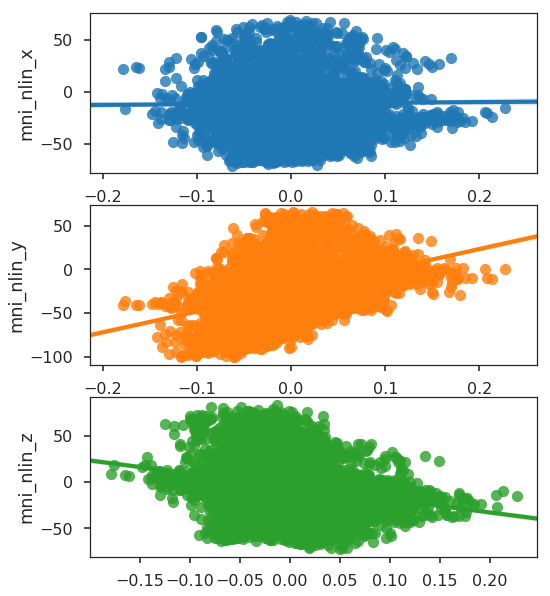

0.000197799513899
0.168571807999
0.0613773455631


In [195]:
# NEW COORDINATES
plt.close()
fig,(ax1, ax2, ax3) = plt.subplots(3, figsize=(8,10))
sns.regplot(np.array(gcx_SPCR), gdf.mni_nlin_x, ax=ax1)
sns.regplot(np.array(gcx_SPCR), gdf.mni_nlin_y, ax=ax2)
sns.regplot(np.array(gcx_SPCR), gdf.mni_nlin_z, ax=ax3)
plt.show()
print(stats.pearsonr(np.array(gcx_SPCR), gdf.mni_nlin_x)[0]**2)
print(stats.pearsonr(np.array(gcx_SPCR), gdf.mni_nlin_y)[0]**2)
print(stats.pearsonr(np.array(gcx_SPCR), gdf.mni_nlin_z)[0]**2)

In [196]:
gdf.loc[:,'AP_axis_gxp_signature_similarity_SPCR'] = gcx_SPCR

In [207]:
#gdf.drop(gdf.columns[16:27],axis=1,inplace=True)

In [38]:
gdf.to_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info.csv'),index=False)

In [217]:
vec = gdf.AP_axis_gxp_signature_similarity_SPCR.values
input_coords = []
for i,row in gdf.iterrows():
    input_coords.append(convert_coords([round(int(row['mni_nlin_x'])), 
                                        round(int(row['mni_nlin_y'])), 
                                        round(int(row['mni_nlin_z']))], 'xyz'))
nm = 'MAIN_SPCR_nlin'
gcx_img = make_expression_image(vec, input_coords, mni, wdir, nm, 3, return_img=True)

In [222]:
jnk = gcx_img.get_data()
len(jnk[jnk!=0])

299344

# Classification

In [224]:
# brainstem cerebellum
for i,row in gdf.iterrows():
    if row['slab_type'] == 'CB':
        gdf.loc[i,'cereb0_bstem1'] = 0
    elif row['slab_type'] == 'BS':
        gdf.loc[i,'cereb0_bstem1'] = 1
c_b_classifier = gdf[pandas.notnull(gdf.cereb0_bstem1)
                    ][['AP_axis_gxp_signature_similarity_SPCR','cereb0_bstem1']]
c_b_classifier.shape

(954, 2)

In [226]:
cb_mod = linear_model.LogisticRegressionCV().fit(
        c_b_classifier['AP_axis_gxp_signature_similarity_SPCR'].values.reshape(-1,1),
                                       c_b_classifier.cereb0_bstem1.values)
cb_mod.score(c_b_classifier['AP_axis_gxp_signature_similarity_SPCR'].values.reshape(-1,1),
             c_b_classifier.cereb0_bstem1)

0.92557651991614254

In [230]:
labs = pandas.read_csv('/home/users/jvogel/git/pycourse/stuff/dst_labels.csv', header=None)
labs.columns = ['integer_label', 'label']

In [232]:
# FRONTAL-OCCIPITAL
frontal = [1,1,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1,1,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
          ] + [1,1,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1,1,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
          ] + [0,0]
labs.loc[:,'frontal'] = frontal
occipital = [0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
             ] + [0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
             ] + [0,0]
#list(zip(labs.label,occipital))
labs.loc[:,'occipital'] = occipital
labs.head()

,integer_label,label,frontal,occipital
0,1,Caudal anterior cingulate,1,0
1,2,Caudal middle frontal,1,0
2,3,Cuneus,0,1
3,4,entorinal,0,0
4,5,fusiform,0,0


In [237]:
dkt = ni.load('/home/users/jvogel/Science/templates/atlases/dkt_atlas_1mm.nii').get_data()

In [238]:
flobe = np.zeros_like(dkt)
olobe = np.zeros_like(dkt)
for i,row in labs.iterrows():
    if row['frontal'] == 1:
        flobe[dkt==row['integer_label']] = 1
    elif row['occipital'] == 1:
        olobe[dkt==row['integer_label']] = 1
ocoords = np.where(olobe==1)
ohits = [[ocoords[0][x], ocoords[1][x], ocoords[2][x]] for x in range(len(ocoords[0]))]

fcoords = np.where(flobe==1)
fhits = [[fcoords[0][x], fcoords[1][x], fcoords[2][x]] for x in range(len(fcoords[0]))]

In [240]:
for i,row in gdf.iterrows():
    tcoords = [int(x) for x in convert_coords([round(row['mni_nlin_x']),
                                   round(row['mni_nlin_y']),round(row['mni_nlin_z'])
                                  ],'xyz')]
    if tcoords in ohits:
        gdf.loc[i,'frontal1_occipital0'] = 0
        print('hit occipital')
    elif tcoords in fhits:
        print('hit frontal')
        gdf.loc[i,'frontal1_occipital0'] = 1

hit occipital
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit occipital
hit frontal
hit frontal
hit frontal
hit occipital
hit occipital
hit occipital
hit occipital
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit occipital
hit occipital
hit occipital
hit frontal
hit occipital
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit occi

In [242]:
f_o_classifier = gdf[pandas.notnull(gdf.frontal1_occipital0)
                    ][['AP_axis_gxp_signature_similarity_SPCR','frontal1_occipital0']]

fo_mod = linear_model.LogisticRegressionCV().fit(
        f_o_classifier['AP_axis_gxp_signature_similarity_SPCR'].values.reshape(-1,1),
                                       f_o_classifier.frontal1_occipital0.values)
fo_mod.score(f_o_classifier['AP_axis_gxp_signature_similarity_SPCR'].values.reshape(-1,1),
             f_o_classifier.frontal1_occipital0)

0.8929133858267716

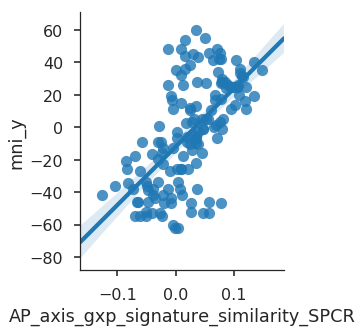

0.392010821703


In [243]:
cings = [x for x in gdf.structure_name.unique() if 'cingulate gyrus' in x]
cingsamps = [i for i in gdf.index if gdf.loc[i,'structure_name'] in cings]
plt.close()
sns.lmplot(x = 'AP_axis_gxp_signature_similarity_SPCR', 
           y = 'mni_y',
           data = gdf.loc[cingsamps] )
plt.show()
print(stats.pearsonr(gdf.loc[cingsamps,'AP_axis_gxp_signature_similarity_SPCR'],
                    gdf.loc[cingsamps,'mni_y'])[0]**2)

In [244]:
amygs = ['basolateral nucleus, left',
'basolateral nucleus, right',
'lateral nucleus, left',
'lateral nucleus, right',
'central nucleus, left',
'central nucleus, right',
'basomedial nucleus, left',
'basomedial nucleus, right',
'amygdalohippocampal transition zone, left',
'amygdalohippocampal transition zone, right']
print('amygdala',len([i for i in gdf.index if gdf.loc[i,'structure_name'] in amygs]))
tpoles = [x for x in gdf.structure_name.unique() if 'temporal pole' in x and 'inferior' in x]
print('tpole',len([i for i in gdf.index if gdf.loc[i,'structure_name'] in tpoles]))
ofronts = [x for x in gdf.structure_name.unique() if 'lateral orbital gyrus' in x]
print('ofront',len([i for i in gdf.index if gdf.loc[i,'structure_name'] in ofronts]))
AT_system = amygs + tpoles + ofronts
AT_samps = [i for i in gdf.index if gdf.loc[i,'structure_name'] in AT_system]
print('whole AT system',len(AT_samps))

amygdala 56
tpole 11
ofront 20
whole AT system 87


In [245]:
mbs = [x for x in gdf.structure_name.unique() if 'mammillary' in x and 'hypothal' not in x]
print('mam bod',len([i for i in gdf.index if gdf.loc[i,'structure_name'] in mbs]))
athal = ['anterior group of nuclei, left','anterior group of nuclei, right']
print('a thalamus',len([i for i in gdf.index if gdf.loc[i,'structure_name'] in athal]))
prec = [x for x in gdf.structure_name.unique() if 'precuneus' in x]
print('precun',len([i for i in gdf.index if gdf.loc[i,'structure_name'] in prec]))
angg = [x for x in gdf.structure_name.unique() if 'angular gyrus' in x]
print('ang gyr',len([i for i in gdf.index if gdf.loc[i,'structure_name'] in angg]))
pccs = [x for x in gdf.structure_name.unique() if 'cingulate' in x and 'parietal' in x]
print('pcc',len([i for i in gdf.index if gdf.loc[i,'structure_name'] in pccs]))
rscs = [x for x in gdf.structure_name.unique() if 'cingulate' in x and 'retrosplenial' in x]
print('rsc',len([i for i in gdf.index if gdf.loc[i,'structure_name'] in rscs]))
PM_system = mbs + athal + prec + angg + pccs + rscs
PM_samps = [i for i in gdf.index if gdf.loc[i,'structure_name'] in PM_system]
print('whole PM system',len(PM_samps))

mam bod 20
a thalamus 28
precun 52
ang gyr 47
pcc 42
rsc 15
whole PM system 204


In [247]:
gdf.loc[AT_samps,'AT0_PM1'] = 0
gdf.loc[PM_samps,'AT0_PM1'] = 1

AT_PM_classifier = gdf[pandas.notnull(gdf.AT0_PM1)
                    ][['AP_axis_gxp_signature_similarity_SPCR','AT0_PM1']]
print('number of samples:', AT_PM_classifier.shape[0])
fo_mod = linear_model.LogisticRegressionCV().fit(
        AT_PM_classifier['AP_axis_gxp_signature_similarity_SPCR'].values.reshape(-1,1),
                                       AT_PM_classifier.AT0_PM1.values)
fo_mod.score(AT_PM_classifier['AP_axis_gxp_signature_similarity_SPCR'].values.reshape(-1,1),
             AT_PM_classifier.AT0_PM1)

number of samples: 291


0.85910652920962194

In [248]:
pred_val = fo_mod.predict(AT_PM_classifier['AP_axis_gxp_signature_similarity_SPCR'
                                          ].values.reshape(-1,1))
AT_PM_classifier.loc[:,'Predicted_label'] = pred_val

In [249]:
gdf.loc[AT_PM_classifier[(AT_PM_classifier.AT0_PM1==0) & (AT_PM_classifier.Predicted_label==1)
                        ].index]['structure_name'].value_counts()

lateral orbital gyrus, left              15
lateral orbital gyrus, right              5
central nucleus, left                     1
temporal pole, right, inferior aspect     1
lateral nucleus, right                    1
temporal pole, left, inferior aspect      1
lateral nucleus, left                     1
basomedial nucleus, left                  1
Name: structure_name, dtype: int64

In [250]:
gdf.loc[AT_PM_classifier[(AT_PM_classifier.AT0_PM1==1) & (AT_PM_classifier.Predicted_label==0)
                        ].index]['structure_name'].value_counts()

lateral mammillary nucleus, left                                      4
tuberomammillary nucleus, left                                        4
supramammillary nucleus, left                                         3
cingulate gyrus, retrosplenial part, left, inferior bank of gyrus     2
cingulate gyrus, retrosplenial part, right, inferior bank of gyrus    1
cingulate gyrus, parietal part, left, superior bank of gyrus          1
Name: structure_name, dtype: int64

In [251]:
# ADD PHG and PRC
phg = ni.load('/home/users/jvogel/ace_mount/ace_home/transfer/FINAL_PHC_mask.nii.gz').get_data()
prc = ni.load('/home/users/jvogel/ace_mount/ace_home/transfer/FINAL_PRC_mask.nii.gz').get_data()
phg_samps = []
prc_samps = []
for i in gdf.index:
    coords = convert_coords(gdf.loc[i,['mni_nlin_x','mni_nlin_y','mni_nlin_z']].tolist(),'xyz')
    xs,ys,zs = make_sphere(coords,3)
    for x in range(len(xs)):
        ph_hits = []
        pr_hits = []
        if phg[xs[x],ys[x],zs[x]] == 1:
            ph_hits.append(x)
        elif prc[xs[x],ys[x],zs[x]] == 1:
            pr_hits.append(x)
    if len(ph_hits) > len(pr_hits):
        print('parahipp')
        phg_samps.append(i)
    elif len(ph_hits) < len(pr_hits):
        print('PERIRHINAL')
        prc_samps.append(i)

PERIRHINAL
parahipp
PERIRHINAL
PERIRHINAL
PERIRHINAL
PERIRHINAL
PERIRHINAL
PERIRHINAL
PERIRHINAL
parahipp
parahipp
parahipp
PERIRHINAL
PERIRHINAL
parahipp
PERIRHINAL
PERIRHINAL
PERIRHINAL


In [252]:
gdf.loc[prc_samps,'structure_name']

376                fusiform gyrus, left, bank of cos
1401               fusiform gyrus, left, bank of cos
1537               fusiform gyrus, left, bank of cos
1538               fusiform gyrus, left, bank of cos
1608     fusiform gyrus, left, lateral bank of gyrus
1615    parahippocampal gyrus, left, bank of the cos
2405    parahippocampal gyrus, left, bank of the cos
2407               fusiform gyrus, left, bank of cos
3203               fusiform gyrus, left, bank of cos
3222              fusiform gyrus, right, bank of cos
3376               fusiform gyrus, left, bank of cos
3402    fusiform gyrus, right, lateral bank of gyrus
3403              fusiform gyrus, right, bank of cos
Name: structure_name, dtype: object

In [253]:
gdf.loc[:,'AT0_PM1_take2'] = gdf.AT0_PM1.values
gdf.loc[prc_samps,'AT0_PM1_take2'] = 0
gdf.loc[phg_samps,'AT0_PM1_take2'] = 1

In [255]:
AT_PM_classifier = gdf[pandas.notnull(gdf.AT0_PM1_take2)
                    ][['AP_axis_gxp_signature_similarity_SPCR','AT0_PM1_take2']]
print('number of samples:', AT_PM_classifier.shape[0])
fo_mod = linear_model.LogisticRegressionCV().fit(
        AT_PM_classifier['AP_axis_gxp_signature_similarity_SPCR'].values.reshape(-1,1),
                                       AT_PM_classifier.AT0_PM1_take2.values)
fo_mod.score(AT_PM_classifier['AP_axis_gxp_signature_similarity_SPCR'].values.reshape(-1,1),
             AT_PM_classifier.AT0_PM1_take2)

number of samples: 309


0.86084142394822005

In [257]:
pred_val = fo_mod.predict(AT_PM_classifier['AP_axis_gxp_signature_similarity_SPCR'
                                          ].values.reshape(-1,1))
AT_PM_classifier.loc[:,'Predicted_label_take2'] = pred_val

In [23]:
1 -26/102

0.7450980392156863

In [24]:
1 - 18/210

0.9142857142857143

In [258]:
gdf.loc[AT_PM_classifier[(AT_PM_classifier.AT0_PM1_take2==1
                         ) & (AT_PM_classifier.Predicted_label_take2==0)
                        ].index]['structure_name'].value_counts()

tuberomammillary nucleus, left                                        4
lateral mammillary nucleus, left                                      4
supramammillary nucleus, left                                         3
cingulate gyrus, retrosplenial part, left, inferior bank of gyrus     2
cingulate gyrus, retrosplenial part, right, inferior bank of gyrus    1
fusiform gyrus, right, bank of cos                                    1
cingulate gyrus, parietal part, left, superior bank of gyrus          1
fusiform gyrus, left, bank of cos                                     1
Name: structure_name, dtype: int64

In [260]:
gdf.loc[AT_PM_classifier[(AT_PM_classifier.AT0_PM1_take2==0
                         ) & (AT_PM_classifier.Predicted_label_take2==1)
                        ].index]['structure_name'].value_counts()

lateral orbital gyrus, left              15
lateral orbital gyrus, right              5
central nucleus, left                     1
temporal pole, right, inferior aspect     1
lateral nucleus, right                    1
temporal pole, left, inferior aspect      1
lateral nucleus, left                     1
basomedial nucleus, left                  1
Name: structure_name, dtype: int64

In [261]:
AT_PM_classifier.loc[:,'struct'] = gdf.loc[AT_PM_classifier.index,'structure_name'].values
newlabs = []
for i,row in AT_PM_classifier.iterrows():
    roi = row['struct']
    if i in phg_samps:
        newlabs.append('parahippocampal')
    elif i in prc_samps:
        newlabs.append('perirhinal')
    elif roi in amygs:
        newlabs.append('amygdala')
    elif roi in tpoles:
        newlabs.append('temporal pole')
    elif roi in ofronts:
        newlabs.append('orbitofrontal')
    elif roi in mbs:
        newlabs.append('mammillary body')
    elif roi in athal:
        newlabs.append('thalamus')
    elif roi in prec:
        newlabs.append('precuneus')
    elif roi in angg:
        newlabs.append('angular gyrus')
    elif roi in pccs:
        newlabs.append('posterior cingulate')
    elif roi in rscs:
        newlabs.append('retrosplenial')
    else:
        print(i,roi)

In [266]:
AT_PM_classifier.loc[:,'s_label'] = newlabs
AT_PM_classifier[AT_PM_classifier.Predicted_label_take2==0
                ]['AP_axis_gxp_signature_similarity_SPCR'].min()

0.051453790719737713

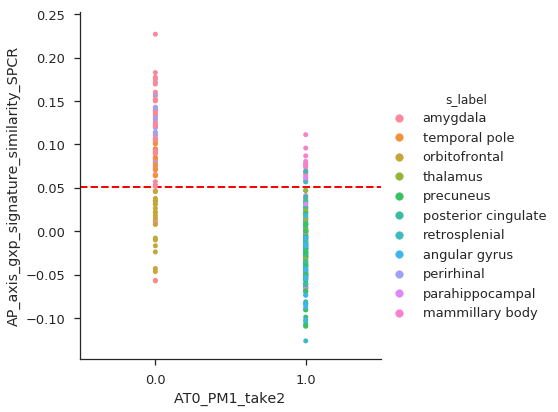

In [267]:
plt.close()
sns.set_context('talk')
sns.set_style('ticks')
sns.factorplot(y = 'AP_axis_gxp_signature_similarity_SPCR',
               x = 'AT0_PM1_take2', kind='strip', hue = 's_label',
               size = 6, aspect=1, data=AT_PM_classifier)
plt.plot([-.5, 1.5], [0.0514, 0.0514], 'r--', linewidth=2)
plt.show()

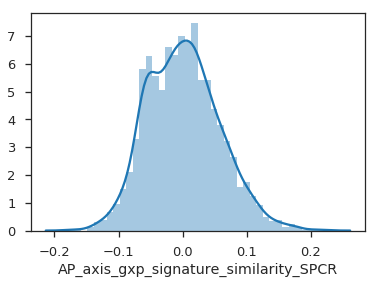

In [268]:
plt.close()
sns.distplot(gdf['AP_axis_gxp_signature_similarity_SPCR'])
plt.show()

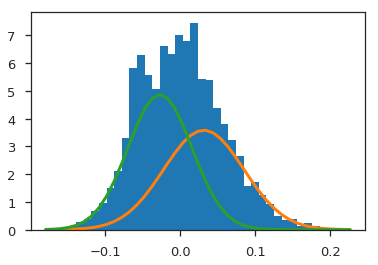

In [275]:
from matplotlib import mlab
GMM2 = mixture.GaussianMixture(n_components=2,random_state=123, tol = 0.00001)
mmod = GMM2.fit(gdf['AP_axis_gxp_signature_similarity_SPCR'].values.reshape(-1,1))
m1, m2 = mmod.means_
w1, w2 = mmod.weights_
c1, c2 = mmod.covariances_
plt.close()
histdist = plt.hist(gdf['AP_axis_gxp_signature_similarity_SPCR'], 40, normed=True)
plotgauss1 = lambda x: plt.plot(x,w1*mlab.normpdf(x,m1,np.sqrt(c1))[0], linewidth=3)
plotgauss2 = lambda x: plt.plot(x,w2*mlab.normpdf(x,m2,np.sqrt(c2))[0], linewidth=3)
plotgauss1(histdist[1])
plotgauss2(histdist[1])
plt.show()



# Resting-state analysis

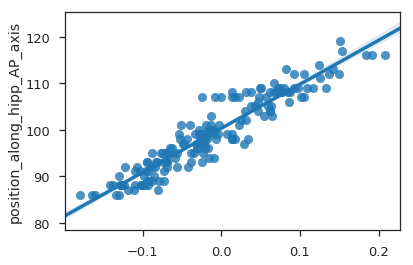

86
119


In [280]:
plt.close()
sns.regplot(np.array(rs),df.position_along_hipp_AP_axis)
plt.show()
print(min(df.position_along_hipp_AP_axis))
print(max(df.position_along_hipp_AP_axis))

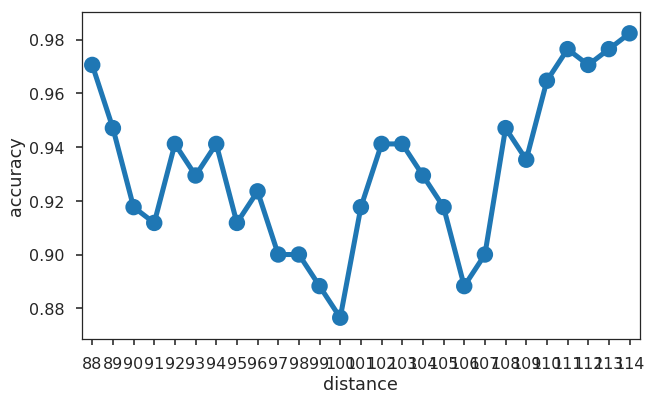

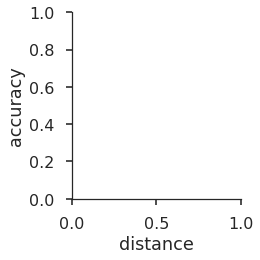

In [281]:
d_classifiers = pandas.DataFrame(index = range(88,115), columns = ['accuracy'])
for i in range(88,115):
    classes = [0 if x < i else 1 for x in df.position_along_hipp_AP_axis]
    tmod = linear_model.LogisticRegressionCV().fit(np.array(rs).reshape(-1,1),classes)
    scr = tmod.score(np.array(rs).reshape(-1,1),classes)
    d_classifiers.loc[i,'accuracy'] = scr
d_classifiers.loc[:,'distance'] = d_classifiers.index

plt.close()
sns.set_context('poster')
fig,ax = plt.subplots(figsize=(10,6))
sns.factorplot(x='distance', y='accuracy', data=d_classifiers, ax=ax)
plt.show()

In [290]:
cx_scans

[]

In [298]:
ascans = sorted(glob('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/rsfmri_neurosynth/*.nii.gz'))
cx_scans = ascans+mscans+pscans
scoords = [[int(x[-3]),int(x[-2]),int(x[-1].split('.')[0])
           ] for x in [y.split('_') for y in cx_scans]]
for i,row in df.iterrows():
    c = [row['mni_nlin_x'],row['mni_nlin_y'],row['mni_nlin_z']]
    dists = [(abs(c[0] - sc[0]) + abs(c[1] - sc[1]) + abs(c[2] - sc[2])) for sc in scoords]
    gcx = np.argmin(dists)
    df.loc[i,'closest_cx_map'] = cx_scans[gcx]


In [301]:
df.head()

,Unnamed: 0,donor,sample,structure_id,slab_num,well_id,slab_type,structure_acronym,structure_name,polygon_id,...,p50_SPCR_avg_gene_expression,gabe_label,mni_nlin_x,mni_nlin_y,mni_nlin_z,basic_idx,position_along_hipp_AP_axis,bilateral_structure_name,bigdf_index,closest_cx_map
basic_idx,,,,,,,,,,,,,,,,,,,,,
0,19,10021,20,4263,17,5707,CX,CA1,"CA1 field, right",1001646,...,0.143594,H0351.2002,21.876385,-42.363260,4.710402,0,86,CA1 field,19,/home/users/jvogel/Science/Allen_Human_Brain_A...
1,20,10021,21,4264,17,5715,CX,CA2,"CA2 field, right",1001641,...,0.736765,H0351.2002,23.899152,-40.879051,8.176524,1,86,CA2 field,20,/home/users/jvogel/Science/Allen_Human_Brain_A...
2,21,10021,22,4265,17,5723,CX,CA3,"CA3 field, right",1001496,...,1.250826,H0351.2002,22.703225,-40.994060,8.301460,2,86,CA3 field,21,/home/users/jvogel/Science/Allen_Human_Brain_A...
3,22,10021,23,4266,17,5731,CX,CA4,"CA4 field, right",1001475,...,1.506346,H0351.2002,22.928779,-41.054804,7.141831,3,86,CA4 field,22,/home/users/jvogel/Science/Allen_Human_Brain_A...
4,23,10021,24,4267,17,5739,CX,DG,"dentate gyrus, right",998739,...,1.588114,H0351.2002,24.115367,-40.962119,7.018704,4,86,dentate gyrus,23,/home/users/jvogel/Science/Allen_Human_Brain_A...


In [302]:
msk2 = np.array(dkt, copy=True)
msk2[msk2>78] = 0
msk2 = np.array(dkt, copy=True)
msk2[msk2>78] = 0
msk3 = np.array(msk2, copy=True)
msk3[dkt==36] = 0
msk3[dkt==75] = 0

24 maps used for posterior, 50 used for anterior


processing anterior image
making mean image
moving to template space
processing posterior image
making mean image
moving to template space
running analysis


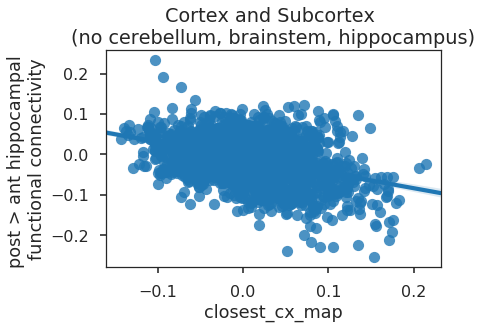

standard statistics: r2 = 0.148600688358, p = 2.01486804344e-70


In [307]:
ant_cut = 94
post_cut = 108
ycol = 'position_along_hipp_AP_axis'
ccol = 'closest_cx_map'
msk = msk3
gcx_col = 'AP_axis_gxp_signature_similarity_SPCR'
plabs = ['Cortex and Subcortex \n(no cerebellum, brainstem, hippocampus)',
         ccol,'post > ant hippocampal \nfunctional connectivity']
run_hipp_connectivity_analysis(ant_cut, post_cut, df, ycol, 
                                   ccol, wdir, gdf, msk, gcx_col, plabs,
                                   del_img = True, diff_img = True,  vrad = 3,
                                  in_imgs = [], bootstrap = False, hue_vals=[])

# Cognitive fmri meta-analysis

In [12]:
#OKAY, NOW REPEAT WITH ALL 100 MAPS
metascans = sorted(glob('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/cognition_mri_analysis/all_maps_RI/r*.nii.gz'))
print(len(metascans))
metascans[0]

100


'/home/users/jvogel/Science/Allen_Human_Brain_Atlas/cognition_mri_analysis/all_maps_RI/rv4-topics-100_0_stimulation_somatosensory_tms_pFgA_z_FDR_0_img.nii.gz'

In [13]:
metalabs = ['T%s_%s_%s'%(os.path.split(x)[-1].split('_')[1],
                         os.path.split(x)[-1].split('_')[3],
                         os.path.split(x)[-1].split('_')[-5]) for x in metascans]
metares_a = pandas.DataFrame(index=gdf.index,columns = metalabs)
metares_a.shape

(3702, 100)

In [14]:
allmetas = image.load_img(metascans).get_data()

In [23]:
for i,row in gdf.iterrows():
    xs,ys,zs = make_sphere(convert_coords([row['mni_nlin_x'],row['mni_nlin_y'],row['mni_nlin_z']],'xyz'), 3)
    for img in range(allmetas.shape[-1]):
        if allmetas[xs,ys,zs,img].mean() > 0:
            metares_a.loc[i,metalabs[img]] = row['AP_axis_gxp_signature_similarity_SPCR']
    if i%100 == 0:
        print('finished %s of 3702'%i)

finished 0 of 3702
finished 100 of 3702
finished 200 of 3702
finished 300 of 3702
finished 400 of 3702
finished 500 of 3702
finished 600 of 3702
finished 700 of 3702
finished 800 of 3702
finished 900 of 3702
finished 1000 of 3702
finished 1100 of 3702
finished 1200 of 3702
finished 1300 of 3702
finished 1400 of 3702
finished 1500 of 3702
finished 1600 of 3702
finished 1700 of 3702
finished 1800 of 3702
finished 1900 of 3702
finished 2000 of 3702
finished 2100 of 3702
finished 2200 of 3702
finished 2300 of 3702
finished 2400 of 3702
finished 2500 of 3702
finished 2600 of 3702
finished 2700 of 3702
finished 2800 of 3702
finished 2900 of 3702
finished 3000 of 3702
finished 3100 of 3702
finished 3200 of 3702
finished 3300 of 3702
finished 3400 of 3702
finished 3500 of 3702
finished 3600 of 3702
finished 3700 of 3702


In [37]:
del(allmetas)

In [24]:
map_sizes = []
for i in range(allmetas.shape[-1]):
    jnk = allmetas[:,:,:,i]
    map_sizes.append(len(jnk[jnk>0]))

In [25]:
map_hits = []
for col in metares_a.columns:
    jnk = metares_a[col]
    map_hits.append(len([x for x in jnk.values if pandas.notnull(x)]))

In [26]:
res_sum = pandas.DataFrame(index = metares_a.columns)
res_sum.loc[:,'mean'] = metares_a.mean().values
res_sum.loc[:,'sem'] = metares_a.sem().values
res_sum.loc[:,'map_size'] = map_sizes
res_sum.loc[:,'map_hits'] = map_hits

In [27]:
res_sum.sort_values('mean').head()

,mean,sem,map_size,map_hits
T29_delayed_pFgA,-0.056070,0.006981,1848,26
T93_eyes_pFgA,-0.037907,0.001905,146429,478
T9_attentional_pFgA,-0.032663,0.002350,107198,258
T88_perception_pFgA,-0.031952,0.002742,92493,217
T36_auditory_pFgA,-0.031202,0.002337,102886,398


In [28]:
goodlabs = metares_a.mean().dropna().index
len(goodlabs)
metaresb = metares_a[goodlabs]
metaresb = metaresb[metaresb.mean().sort_values().index]

In [29]:
ATLabs = ['T65','T60','T17','T20','T90']
PMLabs = ['T56','T24','T40','T14','T75']
for top in res_sum.index:
    tnum = top.split('_')[0]
    if tnum in ATLabs:
        res_sum.loc[top,'system'] = 'AT'
    elif tnum in PMLabs:
        res_sum.loc[top,'system'] = 'PM'
res_sum2 = res_sum.loc[metaresb.columns]

In [30]:
goodlabs = res_sum[res_sum.map_hits>100].index
len(goodlabs)
metares100 = metares_a[goodlabs]
metares100 = metares100[metares100.mean().sort_values().index]

In [31]:
res_sum3 = res_sum.loc[metares100.columns]

In [33]:
len(res_sum3)

60

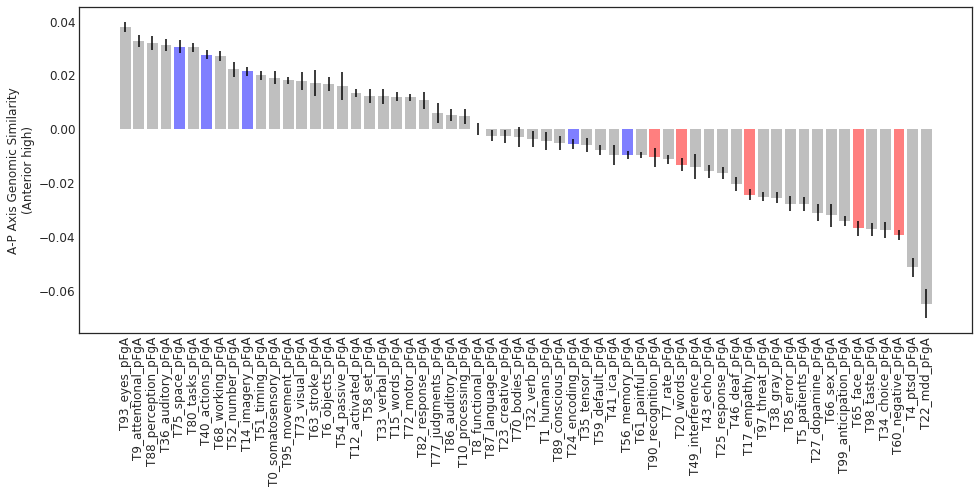

In [32]:
means = (metares100.mean()*-1).tolist()
stds = metares100.sem().tolist()
cis = [((means[x]-stds[x]),(means[x]+stds[x])) for x in range(len(means))]

# get the range of the confidence interval
#y_r = [means[i] - cis[i][1] for i in range(len(cis))]
#y_r = [cis[i][0] - means[i] for i in range(len(cis))]
y_r = [((cis[i][0] - means[i]) + (means[i] - cis[i][1]))/2 for i in range(len(cis))]

colors = ['red' if res_sum3.loc[x,'system'] == 'AT' else 'blue' if res_sum3.loc[x,'system'] == 'PM' else 'gray' for x in metares100.columns]
plt.close()
sns.set_style('white')
fig, ax = plt.subplots(figsize=(16,6))
fig = plt.bar(range(len(means)), means, yerr=y_r, alpha=0.5, align='center', color = colors,
             )
plt.xticks(range(len(means)), metares100.mean().dropna().index.tolist())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('A-P Axis Genomic Similarity\n(Anterior high)')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.show()

In [34]:
goodlabs = res_sum[res_sum.map_hits>500].index
len(goodlabs)
metares500 = metares_a[goodlabs]
metares500 = metares500[metares500.mean().sort_values().index]

In [35]:
res_sum4 = res_sum.loc[metares500.columns]
res_sum4.shape

(24, 5)

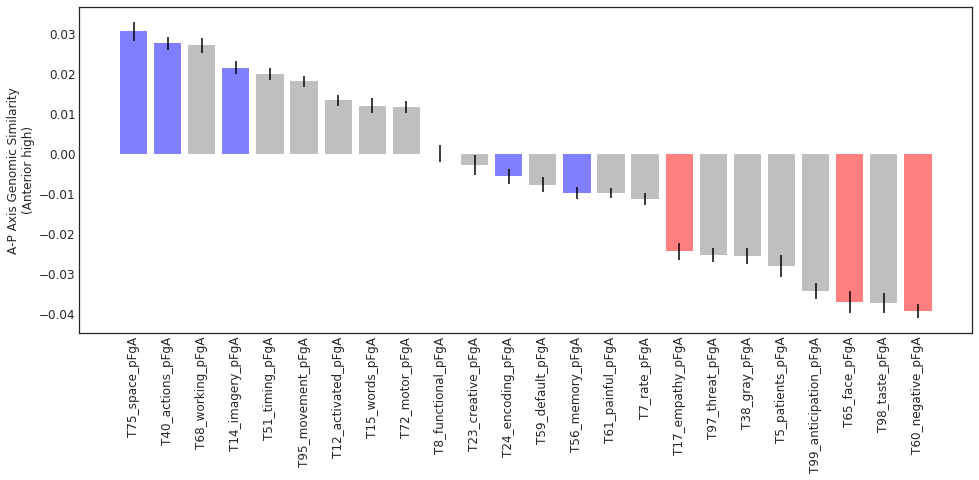

In [36]:
means = (metares500.mean()*-1).tolist()
stds = metares500.sem().tolist()
cis = [((means[x]-stds[x]),(means[x]+stds[x])) for x in range(len(means))]

# get the range of the confidence interval
#y_r = [means[i] - cis[i][1] for i in range(len(cis))]
#y_r = [cis[i][0] - means[i] for i in range(len(cis))]
y_r = [((cis[i][0] - means[i]) + (means[i] - cis[i][1]))/2 for i in range(len(cis))]

colors = ['red' if res_sum4.loc[x,'system'] == 'AT' else 'blue' if res_sum4.loc[x,'system'] == 'PM' else 'gray' for x in metares500.columns]
plt.close()
sns.set_style('white')
fig, ax = plt.subplots(figsize=(16,6))
fig = plt.bar(range(len(means)), means, yerr=y_r, alpha=0.5, align='center', color = colors,
             )
plt.xticks(range(len(means)), metares500.mean().dropna().index.tolist())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('A-P Axis Genomic Similarity\n(Anterior high)')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.show()

# Relative and absolute expression

In [101]:
shtz = sorted(glob(os.path.join(wdir,'normalized_microarray_donor*/PACall.csv')))
holder = []
for sht in shtz:
    jnk = pandas.read_csv(sht,header=None)
    jnk.drop(jnk.columns[0],axis=1,inplace=True)
    holder.append(jnk)
bigdf_b = pandas.concat(holder,axis=1)
del(holder)

In [92]:
hipp_samps = []
for col in xp.columns:
    jnk = col.split('_')
    sub = jnk[0]
    samp = jnk[-1]
    idx = gdf[(gdf.donor==int(sub)) & (gdf['sample']==int(samp))].index
    hipp_samps.append(idx[0])
#hipp_samps = list(np.array(hipp_samps) + 1)

In [102]:
bin_hipp = bigdf_b.iloc[:,hipp_samps]
bin_hipp.shape

(58692, 170)

In [103]:
del(bigdf_b)

In [104]:
bin_hipp_a = bin_hipp.loc[pcalr_out_NEW['gene_selections']['anterior_genes_20']]
bin_hipp_p = bin_hipp.loc[pcalr_out_NEW['gene_selections']['posterior_genes_20']]

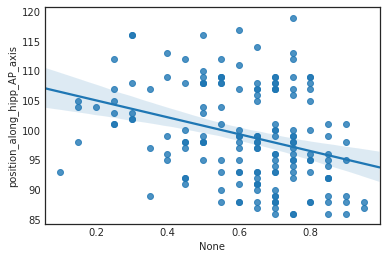

In [105]:
plt.close()
sns.regplot(bin_hipp_a.mean(),df.position_along_hipp_AP_axis)
plt.show()

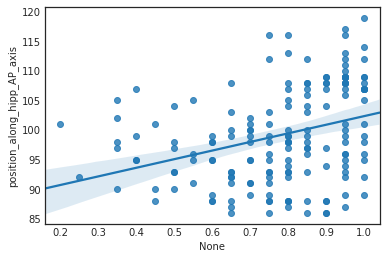

In [106]:
plt.close()
sns.regplot(bin_hipp_p.mean(),df.position_along_hipp_AP_axis)
plt.show()

In [107]:
wdir = '/data1/users/jvogel/Allen_Human_Brain_Atlas/'
shtz = sorted(glob(os.path.join(wdir,'normalized_microarray_donor*/MExp_all_genes_ctr_for_donor')))
holder = []
for sht in shtz:
    holder.append(pandas.read_csv(sht,index_col=0))
bigdf = pandas.concat(holder,axis=1)
del(holder)
ncols = ['%s_%s'%(gdf.loc[x,'donor'],bigdf.columns[x]) for x in range(gdf.shape[0])]
bigdf.columns = ncols

In [108]:
gx_hipp = bigdf.iloc[:,hipp_samps]
gx_hipp_a = gx_hipp.loc[pcalr_out_NEW['gene_selections']['anterior_genes_20']]
gx_hipp_p = gx_hipp.loc[pcalr_out_NEW['gene_selections']['posterior_genes_20']]

In [109]:
del(bigdf)

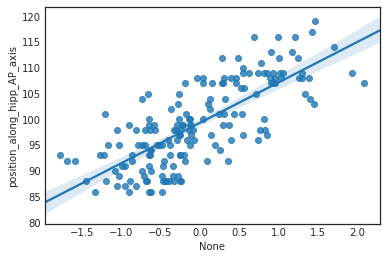

In [112]:
plt.close()
sns.regplot(gx_hipp_p.mean(),df.position_along_hipp_AP_axis)
plt.show()

-5.09279587183


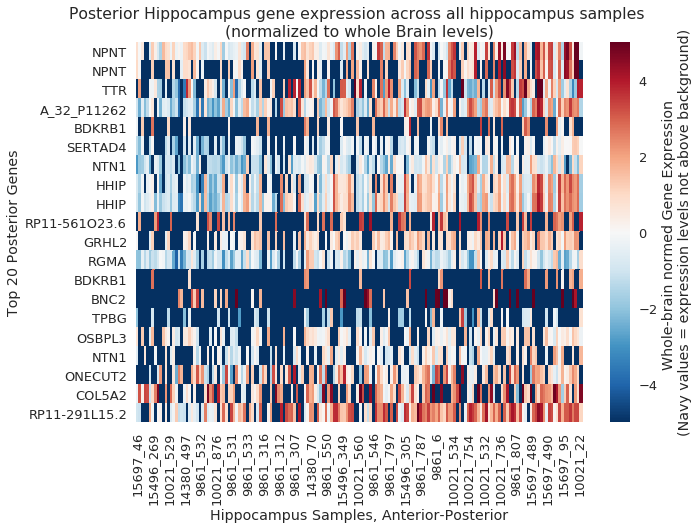

In [145]:
cutdf = pandas.DataFrame(gx_hipp_a,copy=True)
for i in range(cutdf.shape[0]):
    cutdf.loc[cutdf.index[i]] = [cutdf.values[i,x] if bin_hipp_a.values[i,x] == 1 else np.nan for x in range(cutdf.shape[-1])]
minval = min(cutdf.values.flat)
print(minval)
    
cutdf1 = pandas.DataFrame(gx_hipp_a,copy=True)
for i in range(cutdf1.shape[0]):
    cutdf1.loc[cutdf1.index[i]] = [cutdf1.values[i,x] if bin_hipp_a.values[i,x] == 1 else -10 for x in range(cutdf1.shape[-1])]

sortr = pandas.DataFrame(cutdf,copy=True)
sortr.loc['position'] = df.position_along_hipp_AP_axis.values
sortr = sortr.sort_values('position',axis=1,ascending=False)
plotr = cutdf1.loc[cutdf.index.tolist()[::-1],sortr.columns]
plotr.index = probes.loc[plotr.index]['gene_symbol']
plotr

plt.close()
sns.set_context('talk')
fig,ax = plt.subplots(figsize=(10,7))
sns.heatmap(plotr,cmap='RdBu_r',vmin = -5, vmax=5,
            cbar_kws={'label': 'Whole-brain normed Gene Expression \n(Navy values = expression levels not above background)'})
plt.title('Posterior Hippocampus gene expression across all hippocampus samples \n(normalized to whole Brain levels)')
plt.ylabel('Top 20 Posterior Genes')
plt.xlabel('Hippocampus Samples, Anterior-Posterior')
plt.show()

In [122]:
cutdf

,10021_20,10021_21,10021_22,10021_23,10021_24,10021_525,10021_526,10021_527,10021_528,10021_529,...,9861_789,9861_791,9861_793,9861_797,9861_798,9861_799,9861_804,9861_805,9861_806,9861_807
43820,1.058812,3.592791,3.337129,3.338212,2.595539,-0.915433,-0.448805,1.669464,-0.771391,NaN,...,2.453614,3.292602,1.696251,NaN,1.766991,3.319323,0.695606,1.742901,4.103231,3.672764
344,4.668246,0.703532,0.722585,2.147743,NaN,NaN,0.241681,2.062865,2.854403,NaN,...,2.961941,NaN,4.475590,-0.107902,3.393967,NaN,2.240724,5.255354,NaN,1.194308
8963,NaN,1.350806,0.951443,1.871322,2.356249,3.096561,0.899512,NaN,NaN,NaN,...,2.357500,3.327505,NaN,NaN,NaN,1.145729,NaN,NaN,0.876868,2.937765
8893,1.658845,NaN,NaN,NaN,0.628081,-1.428801,0.173698,-0.509996,-0.564533,NaN,...,1.206345,1.231661,1.117121,-0.773712,0.922774,NaN,0.294605,1.836756,NaN,NaN
27030,-0.251839,-0.062505,0.645279,1.038592,1.446768,-0.993442,0.188532,-0.509881,NaN,0.087089,...,NaN,0.647820,NaN,1.362119,NaN,NaN,1.093391,-0.463111,0.387925,NaN
46463,0.771336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.264125,...,0.143653,NaN,0.965291,0.290412,NaN,NaN,-0.725775,1.773795,NaN,NaN
14183,NaN,NaN,NaN,4.063311,8.139112,3.404548,1.285938,NaN,NaN,NaN,...,4.994161,7.381923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44201,1.827222,1.653489,NaN,NaN,2.029669,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.805427,NaN,NaN,NaN
16217,0.898397,-1.410189,-1.713976,-0.231927,-0.248091,-1.767196,-0.580697,-1.863686,-0.847448,-0.903679,...,0.215433,-0.315992,0.952166,-0.554855,0.164416,-0.199337,0.330728,1.298947,-1.338443,0.138894
17633,NaN,1.248755,2.213354,2.265029,1.066242,NaN,-0.122272,-0.273890,NaN,1.115610,...,NaN,0.309602,NaN,1.563101,1.174148,1.602823,1.668291,0.489109,1.504373,1.913614


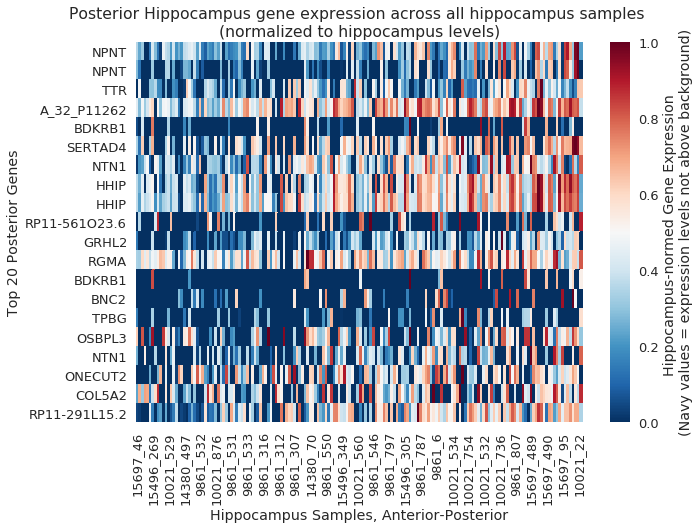

In [126]:
cutdf = pandas.DataFrame(gx_hipp_a,copy=True)
for i in range(cutdf.shape[0]):
    cutdf.loc[cutdf.index[i]] = [cutdf.values[i,x] if bin_hipp_a.values[i,x] == 1 else np.nan for x in range(cutdf.shape[-1])]

mat = np.zeros_like(cutdf.values)
for i in range(cutdf.shape[0]):
    jnk = MinMaxScaler().fit(cutdf.loc[cutdf.index[i]].dropna().values.reshape(-1,1))
    for j,x in enumerate(cutdf.loc[cutdf.index[i]].values):
        if pandas.notnull(x):
            mat[i,j] = jnk.transform(x)
cutdf = pandas.DataFrame(mat, index = cutdf.index, columns = cutdf.columns)

sortr = pandas.DataFrame(cutdf,copy=True)
sortr.loc['position'] = df.position_along_hipp_AP_axis.values
sortr = sortr.sort_values('position',axis=1,ascending=False)
plotr = cutdf.loc[cutdf.index.tolist()[::-1],sortr.columns]
plotr.index = probes.loc[plotr.index]['gene_symbol']

plt.close()
fig,ax = plt.subplots(figsize=(10,7))
sns.heatmap(plotr,cmap='RdBu_r',
            cbar_kws={'label': 'Hippocampus-normed Gene Expression \n(Navy values = expression levels not above background)'})
plt.title('Posterior Hippocampus gene expression across all hippocampus samples \n(normalized to hippocampus levels)')
plt.ylabel('Top 20 Posterior Genes')
plt.xlabel('Hippocampus Samples, Anterior-Posterior')
plt.show()

-5.27886886052


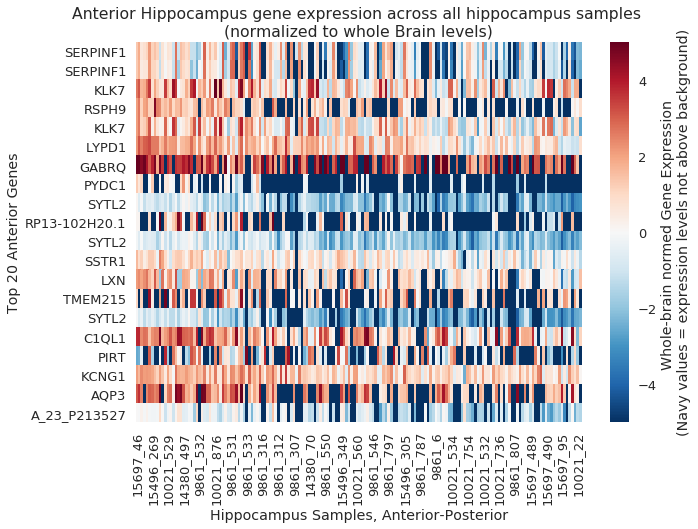

In [147]:
cutdf = pandas.DataFrame(gx_hipp_p,copy=True)
for i in range(cutdf.shape[0]):
    cutdf.loc[cutdf.index[i]] = [cutdf.values[i,x] if bin_hipp_p.values[i,x] == 1 else np.nan for x in range(cutdf.shape[-1])]
minval = min(cutdf.values.flat)
print(minval)
    
cutdf1 = pandas.DataFrame(gx_hipp_p,copy=True)
for i in range(cutdf1.shape[0]):
    cutdf1.loc[cutdf1.index[i]] = [cutdf1.values[i,x] if bin_hipp_p.values[i,x] == 1 else -10 for x in range(cutdf1.shape[-1])]

sortr = pandas.DataFrame(cutdf,copy=True)
sortr.loc['position'] = df.position_along_hipp_AP_axis.values
sortr = sortr.sort_values('position',axis=1,ascending=False)
plotr = cutdf1[sortr.columns]
plotr.index = probes.loc[plotr.index]['gene_symbol']

plt.close()
sns.set_context('talk')
fig,ax = plt.subplots(figsize=(10,7))
sns.heatmap(plotr,cmap='RdBu_r',vmin = -5, vmax = 5, 
            cbar_kws={'label': 'Whole-brain normed Gene Expression \n(Navy values = expression levels not above background)'})
plt.title('Anterior Hippocampus gene expression across all hippocampus samples \n(normalized to whole Brain levels)')
plt.ylabel('Top 20 Anterior Genes')
plt.xlabel('Hippocampus Samples, Anterior-Posterior')
plt.show()

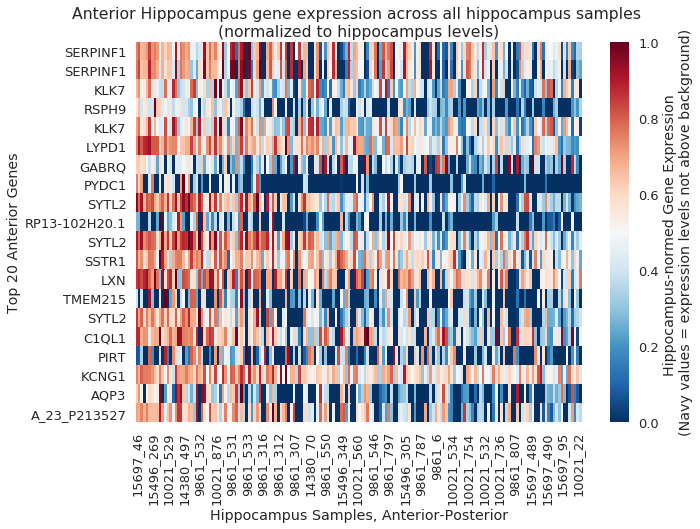

In [128]:
cutdf = pandas.DataFrame(gx_hipp_p,copy=True)
for i in range(cutdf.shape[0]):
    cutdf.loc[cutdf.index[i]] = [cutdf.values[i,x] if bin_hipp_p.values[i,x] == 1 else np.nan for x in range(cutdf.shape[-1])]

mat = np.zeros_like(cutdf.values)
for i in range(cutdf.shape[0]):
    jnk = MinMaxScaler().fit(cutdf.loc[cutdf.index[i]].dropna().values.reshape(-1,1))
    for j,x in enumerate(cutdf.loc[cutdf.index[i]].values):
        if pandas.notnull(x):
            mat[i,j] = jnk.transform(x)
cutdf = pandas.DataFrame(mat, index = cutdf.index, columns = cutdf.columns)

sortr = pandas.DataFrame(cutdf,copy=True)
sortr.loc['position'] = df.position_along_hipp_AP_axis.values
sortr = sortr.sort_values('position',axis=1,ascending=False)
plotr = cutdf[sortr.columns]
plotr.index = probes.loc[plotr.index]['gene_symbol']

plt.close()
fig,ax = plt.subplots(figsize=(10,7))
sns.heatmap(plotr,cmap='RdBu_r',
            cbar_kws={'label': 'Hippocampus-normed Gene Expression \n(Navy values = expression levels not above background)'})
plt.title('Anterior Hippocampus gene expression across all hippocampus samples \n(normalized to hippocampus levels)')
plt.ylabel('Top 20 Anterior Genes')
plt.xlabel('Hippocampus Samples, Anterior-Posterior')
plt.show()

In [129]:
df.loc[:,'a20_SPCR_NEW_expression'] = gx_hipp_a.mean().values
df.loc[:,'a20_SPCR_NEW_bin_xp'] = bin_hipp_a.mean().values
df.loc[:,'p20_SPCR_NEW_expression'] = gx_hipp_p.mean().values
df.loc[:,'p20_SPCR_NEW_bin_xp'] = bin_hipp_p.mean().values

# RENDER RESULTS

In [132]:
input_coords = []
for i,row in df.iterrows():
    input_coords.append(convert_coords([row['mni_nlin_x'], row['mni_nlin_y'], row['mni_nlin_z']],'xyz'))
for col in df.columns[-4:]:
    lab = 'hipp_only_%s'%col
    make_expression_image(df[col], input_coords, projection_space = mni, 
                          wdir = wdir, nm = lab, vrad=3)
    print('finished',lab)

finished hipp_only_a20_SPCR_NEW_expression
finished hipp_only_a20_SPCR_NEW_bin_xp
finished hipp_only_p20_SPCR_NEW_expression
finished hipp_only_p20_SPCR_NEW_bin_xp


In [133]:
a20_hipp_xp = ni.load(
        '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/hipp_only_a20_SPCR_NEW_expression_xp_image.nii.gz'
                    ).get_data()

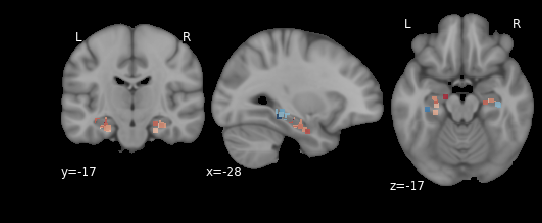

In [136]:
a20_hipp_xp = ni.load(
        '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/hipp_only_a20_SPCR_NEW_expression_xp_image.nii.gz'
                    )
p20_hipp_xp = ni.load(
        '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/hipp_only_p20_SPCR_NEW_expression_xp_image.nii.gz'
                    )
plt.close()
plotting.plot_roi(p20_hipp_xp, mni, draw_cross=False, cmap='RdBu_r')
plt.show()

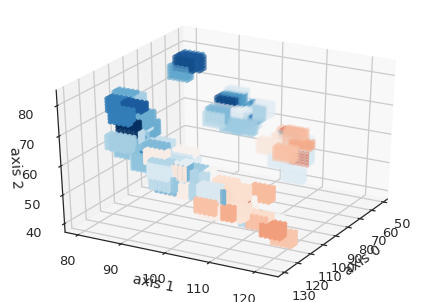

In [137]:
label_locations = np.where(a20_hipp_xp.get_data() != 0)
#label_locations1 = np.where(ap_axis.get_data() > 0)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(label_locations[0], label_locations[1], label_locations[2], c = a20_hipp_xp.get_data()[label_locations],
          cmap='RdBu')
# To split into LR, we need to visualize where the LR split is, where front is
for angle in range(0, 30):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
plt.show()



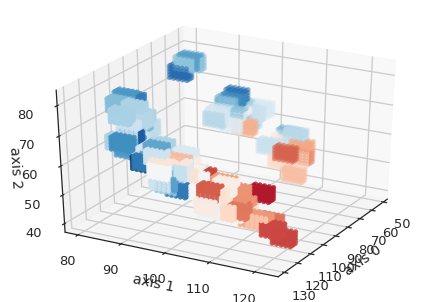

In [139]:
label_locations = np.where(p20_hipp_xp.get_data() != 0)
#label_locations1 = np.where(ap_axis.get_data() > 0)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(label_locations[0], label_locations[1], label_locations[2], c = p20_hipp_xp.get_data()[label_locations],
          cmap='RdBu_r')
# To split into LR, we need to visualize where the LR split is, where front is
for angle in range(0, 30):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
plt.show()



# GSEA Analysis

In [42]:
gsea = pandas.read_table('/Users/jakevogel/Downloads/overlap')
gsea.head()

,Entrez Gene Id,Gene Symbol,Gene Description,GO_NEGATIVE_REGULATION_OF_MULTICELLULAR_ORGANISMAL_PROCESS,GO_INTRINSIC_COMPONENT_OF_PLASMA_MEMBRANE,GO_SIGNALING_RECEPTOR_ACTIVITY,GO_REGULATION_OF_MULTICELLULAR_ORGANISMAL_DEVELOPMENT,GO_SIGNAL_TRANSDUCER_ACTIVITY,GO_REGULATION_OF_CELL_DIFFERENTIATION,GO_CELL_PROJECTION,GO_REGULATION_OF_ANATOMICAL_STRUCTURE_MORPHOGENESIS,GO_TISSUE_DEVELOPMENT,GO_ORGAN_MORPHOGENESIS
0,4986,OPRK1,"opioid receptor, kappa 1",GO_NEGATIVE_REGULATION_OF_MULTICELLULAR_ORGANI...,GO_INTRINSIC_COMPONENT_OF_PLASMA_MEMBRANE,GO_SIGNALING_RECEPTOR_ACTIVITY,GO_SIGNAL_TRANSDUCER_ACTIVITY,GO_CELL_PROJECTION,NaN,NaN,NaN,NaN,NaN
1,3084,NRG1,neuregulin 1,GO_NEGATIVE_REGULATION_OF_MULTICELLULAR_ORGANI...,GO_INTRINSIC_COMPONENT_OF_PLASMA_MEMBRANE,GO_REGULATION_OF_MULTICELLULAR_ORGANISMAL_DEVE...,GO_SIGNAL_TRANSDUCER_ACTIVITY,GO_REGULATION_OF_CELL_DIFFERENTIATION,GO_CELL_PROJECTION,GO_REGULATION_OF_ANATOMICAL_STRUCTURE_MORPHOGE...,GO_TISSUE_DEVELOPMENT,GO_ORGAN_MORPHOGENESIS,NaN
2,51083,GAL,galanin prepropeptide,GO_NEGATIVE_REGULATION_OF_MULTICELLULAR_ORGANI...,GO_SIGNALING_RECEPTOR_ACTIVITY,GO_REGULATION_OF_MULTICELLULAR_ORGANISMAL_DEVE...,GO_SIGNAL_TRANSDUCER_ACTIVITY,GO_REGULATION_OF_CELL_DIFFERENTIATION,GO_REGULATION_OF_ANATOMICAL_STRUCTURE_MORPHOGE...,NaN,NaN,NaN,NaN
3,7026,NR2F2,"nuclear receptor subfamily 2, group F, member 2",GO_NEGATIVE_REGULATION_OF_MULTICELLULAR_ORGANI...,GO_SIGNALING_RECEPTOR_ACTIVITY,GO_SIGNAL_TRANSDUCER_ACTIVITY,GO_TISSUE_DEVELOPMENT,NaN,NaN,NaN,NaN,NaN,NaN
4,5176,SERPINF1,"serpin peptidase inhibitor, clade F (alpha-2 a...",GO_NEGATIVE_REGULATION_OF_MULTICELLULAR_ORGANI...,GO_REGULATION_OF_MULTICELLULAR_ORGANISMAL_DEVE...,GO_REGULATION_OF_CELL_DIFFERENTIATION,GO_CELL_PROJECTION,GO_REGULATION_OF_ANATOMICAL_STRUCTURE_MORPHOGE...,NaN,NaN,NaN,NaN,NaN


In [29]:
gsea.columns

Index(['Entrez Gene Id', 'Gene Symbol', 'Gene Description',
       'GO_NEGATIVE_REGULATION_OF_MULTICELLULAR_ORGANISMAL_PROCESS',
       'GO_INTRINSIC_COMPONENT_OF_PLASMA_MEMBRANE',
       'GO_SIGNALING_RECEPTOR_ACTIVITY',
       'GO_REGULATION_OF_MULTICELLULAR_ORGANISMAL_DEVELOPMENT',
       'GO_SIGNAL_TRANSDUCER_ACTIVITY',
       'GO_REGULATION_OF_CELL_DIFFERENTIATION', 'GO_CELL_PROJECTION',
       'GO_REGULATION_OF_ANATOMICAL_STRUCTURE_MORPHOGENESIS',
       'GO_TISSUE_DEVELOPMENT', 'GO_ORGAN_MORPHOGENESIS'],
      dtype='object')

In [49]:
ngsea = pandas.DataFrame(np.zeros_like(gsea.values),copy=True)
ngsea.columns = gsea.columns
for col in gsea.columns[:3]:
    ngsea.loc[:,col] = gsea[col].values

In [50]:
for i in gsea.index:
    for col in gsea.columns[3:]:
        val = gsea.loc[i,col]
        if pandas.notnull(val):
            ngsea.loc[i,val] = 1

In [52]:
ngsea.head()

,Entrez Gene Id,Gene Symbol,Gene Description,GO_NEGATIVE_REGULATION_OF_MULTICELLULAR_ORGANISMAL_PROCESS,GO_INTRINSIC_COMPONENT_OF_PLASMA_MEMBRANE,GO_SIGNALING_RECEPTOR_ACTIVITY,GO_REGULATION_OF_MULTICELLULAR_ORGANISMAL_DEVELOPMENT,GO_SIGNAL_TRANSDUCER_ACTIVITY,GO_REGULATION_OF_CELL_DIFFERENTIATION,GO_CELL_PROJECTION,GO_REGULATION_OF_ANATOMICAL_STRUCTURE_MORPHOGENESIS,GO_TISSUE_DEVELOPMENT,GO_ORGAN_MORPHOGENESIS
0,4986,OPRK1,"opioid receptor, kappa 1",1,1,1,0,1,0,1,0,0,0
1,3084,NRG1,neuregulin 1,1,1,0,1,1,1,1,1,1,1
2,51083,GAL,galanin prepropeptide,1,0,1,1,1,1,0,1,0,0
3,7026,NR2F2,"nuclear receptor subfamily 2, group F, member 2",1,0,1,0,1,0,0,0,1,0
4,5176,SERPINF1,"serpin peptidase inhibitor, clade F (alpha-2 a...",1,0,0,1,0,1,1,1,0,0


In [53]:
gsea = ngsea

In [54]:
for i,row in gsea.iterrows():
    if row['Gene Symbol'] in probes.loc[pcalr_out_NEW['gene_selections']['anterior_genes_50']
                                       ]['gene_symbol'].tolist():
        gsea.loc[i,'Location'] = 'POST'
    elif row['Gene Symbol'] in probes.loc[pcalr_out_NEW['gene_selections']['posterior_genes_50']
                                        ]['gene_symbol'].tolist():
        gsea.loc[i,'Location'] = 'ANT'
    else:
        gsea.loc[i,'Location'] = 'ANT'

In [55]:
for col in gsea.columns[3:-1]:
    print(col)
    asum = gsea[gsea.Location=='ANT'][col].sum()
    psum = gsea[gsea.Location=='POST'][col].sum()
    print('Anterior: %s,  Posterior: %s \n'%(asum,psum))

GO_NEGATIVE_REGULATION_OF_MULTICELLULAR_ORGANISMAL_PROCESS
Anterior: 8,  Posterior: 5 

GO_INTRINSIC_COMPONENT_OF_PLASMA_MEMBRANE
Anterior: 10,  Posterior: 5 

GO_SIGNALING_RECEPTOR_ACTIVITY
Anterior: 10,  Posterior: 4 

GO_REGULATION_OF_MULTICELLULAR_ORGANISMAL_DEVELOPMENT
Anterior: 7,  Posterior: 8 

GO_SIGNAL_TRANSDUCER_ACTIVITY
Anterior: 11,  Posterior: 4 

GO_REGULATION_OF_CELL_DIFFERENTIATION
Anterior: 7,  Posterior: 7 

GO_CELL_PROJECTION
Anterior: 8,  Posterior: 7 

GO_REGULATION_OF_ANATOMICAL_STRUCTURE_MORPHOGENESIS
Anterior: 6,  Posterior: 6 

GO_TISSUE_DEVELOPMENT
Anterior: 5,  Posterior: 9 

GO_ORGAN_MORPHOGENESIS
Anterior: 3,  Posterior: 8 



In [56]:
gsea.columns

Index(['Entrez Gene Id', 'Gene Symbol', 'Gene Description',
       'GO_NEGATIVE_REGULATION_OF_MULTICELLULAR_ORGANISMAL_PROCESS',
       'GO_INTRINSIC_COMPONENT_OF_PLASMA_MEMBRANE',
       'GO_SIGNALING_RECEPTOR_ACTIVITY',
       'GO_REGULATION_OF_MULTICELLULAR_ORGANISMAL_DEVELOPMENT',
       'GO_SIGNAL_TRANSDUCER_ACTIVITY',
       'GO_REGULATION_OF_CELL_DIFFERENTIATION', 'GO_CELL_PROJECTION',
       'GO_REGULATION_OF_ANATOMICAL_STRUCTURE_MORPHOGENESIS',
       'GO_TISSUE_DEVELOPMENT', 'GO_ORGAN_MORPHOGENESIS', 'Location'],
      dtype='object')

In [63]:
org_proc = [0,0,0,1,0,0,1,0,1,1,1,1,1,0]
org_proc = [gsea.columns[x] for x in range(len(org_proc)) if org_proc[x]==1]
plas_mem = [0,0,0,0,1,1,0,1,0,0,0,0,0,0]
plas_mem = [gsea.columns[x] for x in range(len(plas_mem)) if plas_mem[x]==1]
ant_op = gsea[gsea.Location=='ANT'][org_proc].sum().sum()
post_op = gsea[gsea.Location=='POST'][org_proc].sum().sum()
ant_pm = gsea[gsea.Location=='ANT'][plas_mem].sum().sum()
post_pm = gsea[gsea.Location=='POST'][plas_mem].sum().sum()
print('Organismal Process ---> ANTERIOR: %s, POSTERIOR: %s \n'%(ant_op,post_op))
print('Plasma membrane ---> ANTERIOR: %s, POSTERIOR: %s '%(ant_pm,post_pm))

Organismal Process ---> ANTERIOR: 44.0, POSTERIOR: 50.0 

Plasma membrane ---> ANTERIOR: 31.0, POSTERIOR: 13.0 


In [64]:
p_gsea = pandas.DataFrame(gsea,copy=True)
new_order = gsea.columns[:3].tolist() + org_proc + plas_mem + ['Location']
p_gsea.reindex(columns = new_order)
p_gsea.head()

,Entrez Gene Id,Gene Symbol,Gene Description,GO_NEGATIVE_REGULATION_OF_MULTICELLULAR_ORGANISMAL_PROCESS,GO_INTRINSIC_COMPONENT_OF_PLASMA_MEMBRANE,GO_SIGNALING_RECEPTOR_ACTIVITY,GO_REGULATION_OF_MULTICELLULAR_ORGANISMAL_DEVELOPMENT,GO_SIGNAL_TRANSDUCER_ACTIVITY,GO_REGULATION_OF_CELL_DIFFERENTIATION,GO_CELL_PROJECTION,GO_REGULATION_OF_ANATOMICAL_STRUCTURE_MORPHOGENESIS,GO_TISSUE_DEVELOPMENT,GO_ORGAN_MORPHOGENESIS,Location
0,4986,OPRK1,"opioid receptor, kappa 1",1,1,1,0,1,0,1,0,0,0,ANT
1,3084,NRG1,neuregulin 1,1,1,0,1,1,1,1,1,1,1,ANT
2,51083,GAL,galanin prepropeptide,1,0,1,1,1,1,0,1,0,0,POST
3,7026,NR2F2,"nuclear receptor subfamily 2, group F, member 2",1,0,1,0,1,0,0,0,1,0,ANT
4,5176,SERPINF1,"serpin peptidase inhibitor, clade F (alpha-2 a...",1,0,0,1,0,1,1,1,0,0,ANT


In [88]:
for i,row in p_gsea.iterrows():
    for col in p_gsea.columns[3:]:
        if row[col] == 1 and row['Location'] == 'POST':
            p_gsea.loc[i,col] = -1
p_gsea.head()

In [99]:
for i in p_gsea.index:
    if all(p_gsea.loc[i,org_proc+plas_mem]==0):
        p_gsea.drop(i,inplace=True)

In [105]:
p_gsea = p_gsea.sort_values('Location')

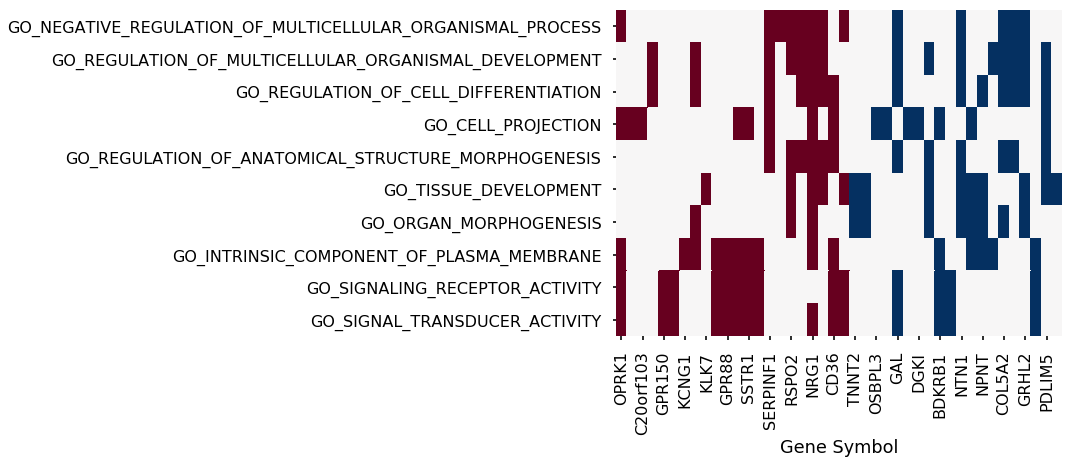

In [110]:
p_gsea.index = p_gsea['Gene Symbol']
pmap = p_gsea[org_proc+plas_mem]
plt.close()
fig,ax = plt.subplots(figsize=(8,6))
sns.heatmap(pmap.astype(int).T,cmap='RdBu_r',cbar=False)
plt.show()

In [74]:
pmap.dropna().shape

(61, 10)

In [115]:
probes.loc[pcalr_out_NEW['gene_selections']['anterior_genes_20']
          ]['gene_symbol'].tolist()

['RP11-291L15.2',
 'COL5A2',
 'ONECUT2',
 'NTN1',
 'OSBPL3',
 'TPBG',
 'BNC2',
 'BDKRB1',
 'RGMA',
 'GRHL2',
 'RP11-561O23.6',
 'HHIP',
 'HHIP',
 'NTN1',
 'SERTAD4',
 'BDKRB1',
 'A_32_P11262',
 'TTR',
 'NPNT',
 'NPNT']

In [117]:
pgenes = pandas.ExcelFile('/Users/jakevogel/Science/AHBA/genes.xlsx').parse('Sheet4')
pgenes.head()

,COL5A2_term,COL5A2_r,ONECUT2_term,ONECUT2_r,NTN1_term,NTN1_r,OSBPL3_term,OSBPL3_r,TPBG_term,TPBG_r,...,GRHL2_term,GRHL2_r,HHIP_term,HHIP_r,SERTAD4_term,SERTAD4_r,TTR_term,TTR_r,NPNT_term,NPNT_r
0,parietal,0.191,caudate,0.323,brainstem,0.412,parietal,0.148,caudate,0.166,...,visual,0.173,ganglia,0.232,visual,0.158,parahippocampal,0.169,substantia,0.213
1,semantic,0.147,striatal,0.304,midbrain,0.350,somatosensory,0.127,caudate nucleus,0.149,...,intraparietal,0.137,basal ganglia,0.231,occipital,0.135,lobe mtl,0.147,midbrain,0.212
2,words,0.145,caudate nucleus,0.277,nuclei,0.274,premotor,0.126,parietal,0.149,...,occipital,0.136,basal,0.230,parietal,0.132,parahippocampal gyrus,0.140,reward,0.200
3,intraparietal,0.144,striatum,0.227,periaqueductal,0.260,m1,0.125,striatal,0.137,...,parietal,0.131,thalamus,0.196,striatal,0.124,parahippocampal cortex,0.137,striatum,0.175
4,intraparietal sulcus,0.136,basal ganglia,0.225,thalamus,0.260,premotor cortex,0.125,premotor,0.122,...,intraparietal sulcus,0.127,subcortical,0.177,m1,0.118,mtl,0.136,ventral striatum,0.170


In [118]:
u_terms = []
for col in pgenes.columns:
    if 'term' in col:
        for term in pgenes[col].unique():
            if term not in u_terms:
                u_terms.append(term)

In [119]:
len(u_terms)

513

In [127]:
pg_res = pandas.DataFrame(np.zeros((len(u_terms),2)),index = u_terms, columns = ['hit','r_sum'])
for i in pgenes.index:
    for col in [x for x in pgenes.columns if 'term' in x]:
        gene = col.split('_')[0]
        val = pgenes.loc[i,col]
        pg_res.loc[val,'hit'] = pg_res.loc[val,'hit'] + 1
        pg_res.loc[val,'r_sum'] = pg_res.loc[val,'r_sum'] + pgenes.loc[i,'%s_r'%gene]
        

In [131]:
pg_res.sort_values('hit',ascending=False).head()

,hit,r_sum
motor cortex,9.0,0.772
motor,8.0,0.757
striatum,8.0,0.837
primary motor,8.0,0.751
primary,8.0,0.688


In [132]:
pg_res.sort_values('r_sum',ascending=False).head()

,hit,r_sum
midbrain,5.0,1.069
parietal,7.0,0.987
brainstem,5.0,0.967
striatal,7.0,0.960
thalamus,6.0,0.947


In [133]:
probes.loc[pcalr_out_NEW['gene_selections']['posterior_genes_20']
          ]['gene_symbol'].tolist()

['SERPINF1',
 'SERPINF1',
 'KLK7',
 'RSPH9',
 'KLK7',
 'LYPD1',
 'GABRQ',
 'PYDC1',
 'SYTL2',
 'RP13-102H20.1',
 'SYTL2',
 'SSTR1',
 'LXN',
 'TMEM215',
 'SYTL2',
 'C1QL1',
 'PIRT',
 'KCNG1',
 'AQP3',
 'A_23_P213527']

## Fill in the hippocampus

In [17]:
#jnk = ni.load('/usr/local/fsl/data/atlases/HarvardOxford/HarvardOxford-sub-maxprob-thr25-1mm.nii.gz')
jnk = ni.load('/usr/share/fsl/5.0/data/atlases/HarvardOxford/HarvardOxford-sub-maxprob-thr25-1mm.nii.gz')
atlas = jnk.get_data()
aff = jnk.affine

In [18]:
hipp = np.zeros_like(atlas)
hipp[(atlas==9) | (atlas==19)] = 1
nhipp = ni.Nifti1Image(hipp, aff)

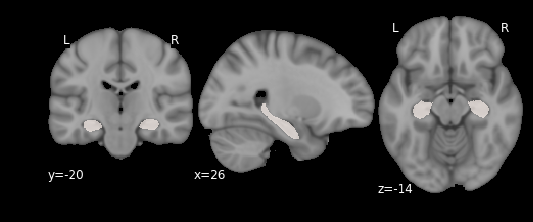

In [19]:
#mni = ni.load('/Users/jakevogel/Science/tau/MNI152_T1_1mm_brain.nii')
mni = ni.load('/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii')
plt.close()
plotting.plot_roi(nhipp, mni, draw_cross=False, cmap='Reds')
plt.show()

In [19]:
hipp = nhipp.get_data()
hcoods = np.where(hipp==1)

In [21]:
s_coords = [convert_coords([round(df.mni_nlin_x[x]),
                 round(df.mni_nlin_y[x]), 
                round(df.mni_nlin_z[x])],'xyz') for x in range(df.shape[0])]

In [22]:
vox = pandas.DataFrame(index=range(len(hcoods[0])),columns=['x','y','z','ind'])
for c in range(len(hcoods[0])):
    cord = [hcoods[0][c], hcoods[1][c], hcoods[2][c]]
    dists = [abs(cord[0] - s_coords[x][0]) + \
             abs(cord[1] - s_coords[x][1]) + \
             abs(cord[2] - s_coords[x][2]) for x in range(len(s_coords))]
    vox.loc[c, ['x','y','z']] = cord
    vox.loc[c,'ind'] = np.argmin(dists)
    if c%1000 == 0:
        print('finished',c)

finished 0
finished 1000
finished 2000
finished 3000
finished 4000
finished 5000
finished 6000
finished 7000
finished 8000
finished 9000
finished 10000
finished 11000


In [85]:
vox.to_csv(os.path.join(wdir,'MAIN_vox_mapping.csv'),index=False)

In [29]:
vox = pandas.read_csv(os.path.join(wdir,'MAIN_vox_mapping.csv')).astype(int)

In [62]:
df.columns[-1]

'position_along_hipp_AP_axis'

In [30]:
p_vec = [xp.loc[pcalr_out_NEW['gene_selections']['posterior_genes_20'],xp.columns[x]
              ].mean() for x in range(xp.shape[1])]
a_vec = [xp.loc[pcalr_out_NEW['gene_selections']['anterior_genes_20'],xp.columns[x]
              ].mean() for x in range(xp.shape[1])]

In [31]:
rend_hipp_p = np.zeros_like(hipp)
for i,row in vox.iterrows():
    rend_hipp_p[row['x'],row['y'],row['z']] = p_vec[row['ind']]

In [32]:
rend_hipp_a = np.zeros_like(hipp)
for i,row in vox.iterrows():
    rend_hipp_a[row['x'],row['y'],row['z']] = a_vec[row['ind']]

In [29]:
max(rend_hipp_a.flat)

1.4992946

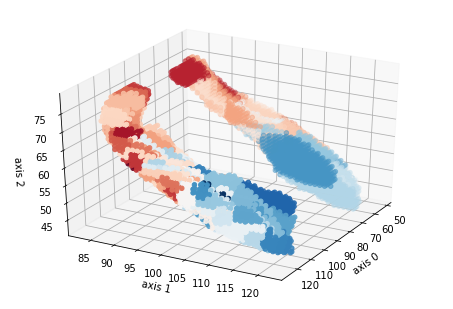

In [33]:
label_locations = np.where(hipp == 1)
#label_locations1 = np.where(ap_axis.get_data() > 0)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(label_locations[0], label_locations[1], label_locations[2], c = rend_hipp_p[label_locations],
          cmap='RdBu')
# To split into LR, we need to visualize where the LR split is, where front is
for angle in range(0, 30):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
plt.show()


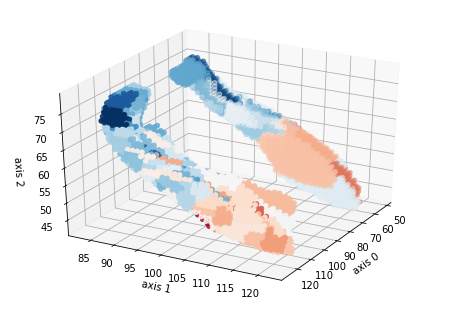

In [31]:
label_locations = np.where(hipp == 1)
#label_locations1 = np.where(ap_axis.get_data() > 0)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(label_locations[0], label_locations[1], label_locations[2], c = rend_hipp_a[label_locations],
          cmap='RdBu')
# To split into LR, we need to visualize where the LR split is, where front is
for angle in range(0, 30):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
plt.show()



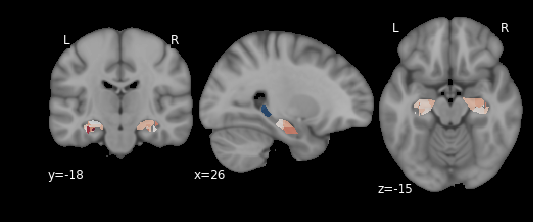

In [32]:
#mni = ni.load('/Users/jakevogel/Science/tau/MNI152_T1_1mm_brain.nii')
plt.close()
plotting.plot_roi(ni.Nifti1Image(rend_hipp_a, aff), mni, draw_cross=False, cmap='RdBu')
plt.show()

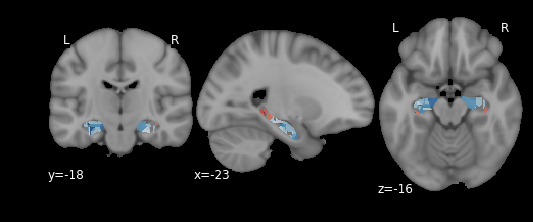

In [33]:
#mni = ni.load('/Users/jakevogel/Science/tau/MNI152_T1_1mm_brain.nii')
plt.close()
plotting.plot_roi(ni.Nifti1Image(rend_hipp_p, aff), mni, draw_cross=False, cmap='RdBu')
plt.show()

In [115]:
for y in coord:
    print([y + x for x in range(-1,2)])

[51, 52, 53]
[100, 101, 102]
[59, 60, 61]


In [107]:
len(make_cube(cord,radius=2)[0])

27

In [81]:
for c in range(len(hcoods[0])):
    cord = [hcoods[0][c], hcoods[1][c], hcoods[2][c]]
    if any(hipp[make_cube(cord,2)]==0):
        vox.loc[c,'surface'] = 1
    else:
        vox.loc[c,'surface'] = 0
    if c%1000 == 0:
        print('finished',c)

finished 0
finished 1000
finished 2000
finished 3000
finished 4000
finished 5000
finished 6000
finished 7000
finished 8000
finished 9000
finished 10000
finished 11000


In [39]:
surf_vox = pandas.DataFrame(vox[vox.surface==1],copy=True)

In [40]:
len(sample_surf_ind)

3702

In [42]:
df.columns

Index(['Unnamed: 0', 'donor', 'sample', 'structure_id', 'slab_num', 'well_id',
       'slab_type', 'structure_acronym', 'structure_name', 'polygon_id',
       'mri_voxel_x', 'mri_voxel_y', 'mri_voxel_z', 'mni_x', 'mni_y', 'mni_z',
       'gabe_label', 'mni_nlin_x', 'mni_nlin_y', 'mni_nlin_z',
       'position_along_hipp_AP_axis'],
      dtype='object')

In [43]:
sample_surf_ind = []
arr = surf_vox[['x','y','z']].values
for i,row in df.iterrows():
    cord = convert_coords([row['mni_nlin_x'],row['mni_nlin_y'],row['mni_nlin_z']],'xyz')
    dists = [abs(cord[0] - arr[x,0]) + \
             abs(cord[1] -  arr[x,1]) + \
             abs(cord[2] -  arr[x,2]) for x in range(surf_vox.shape[0])]
    sample_surf_ind.append(np.argmin(dists))
    if i%50 == 0:
        print('finished',i)

finished 0


In [44]:
len(sample_surf_ind)

170

In [45]:
df.loc[:,'surface_coordinate_index'] = sample_surf_ind

In [48]:
surf_vox = surf_vox.astype(int)

In [49]:
rend_hipp_p2 = np.zeros_like(hipp)
for i,row in surf_vox.iloc[sample_surf_ind].iterrows():
    rend_hipp_p2[row['x'],row['y'],row['z']] = p_vec[row['ind']]

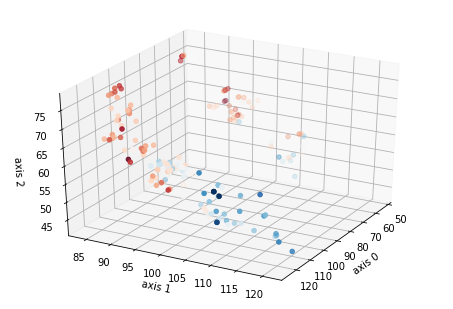

In [50]:
plt.close()
label_locations = [surf_vox.iloc[sample_surf_ind]['x'].tolist(),
                   surf_vox.iloc[sample_surf_ind]['y'].tolist(),
                   surf_vox.iloc[sample_surf_ind]['z'].tolist()]
#label_locations1 = np.where(ap_axis.get_data() > 0)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(label_locations[0], label_locations[1], label_locations[2], c = rend_hipp_p2[label_locations],
          cmap='RdBu')
# To split into LR, we need to visualize where the LR split is, where front is
for angle in range(0, 30):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
plt.show()



In [51]:
rend_hipp_a2 = np.zeros_like(hipp)
for i,row in surf_vox.iloc[sample_surf_ind].iterrows():
    rend_hipp_a2[row['x'],row['y'],row['z']] = a_vec[row['ind']]

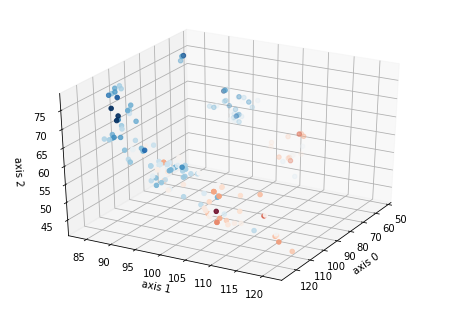

In [52]:
plt.close()
label_locations = [surf_vox.iloc[sample_surf_ind]['x'].tolist(),
                   surf_vox.iloc[sample_surf_ind]['y'].tolist(),
                   surf_vox.iloc[sample_surf_ind]['z'].tolist()]
#label_locations1 = np.where(ap_axis.get_data() > 0)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(label_locations[0], label_locations[1], label_locations[2], c = rend_hipp_a2[label_locations],
          cmap='RdBu')
# To split into LR, we need to visualize where the LR split is, where front is
for angle in range(0, 30):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
plt.show()



In [56]:
rend_hipp_p2[rend_hipp_p2>0].shape

(63,)

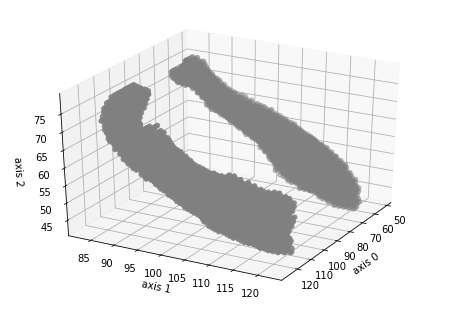

In [59]:
plt.close()
label_locations = [surf_vox.iloc[sample_surf_ind]['x'].tolist(),
                   surf_vox.iloc[sample_surf_ind]['y'].tolist(),
                   surf_vox.iloc[sample_surf_ind]['z'].tolist()]
hipp_labels = np.where(hipp == 1)
#label_locations1 = np.where(ap_axis.get_data() > 0)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(hipp_labels[0], hipp_labels[1], hipp_labels[2], c = 'gray')
#ax2 = Axes3D(fig)
ax.scatter(label_locations[0], label_locations[1], label_locations[2], c = rend_hipp_a2[label_locations],
          cmap='RdBu')
#To split into LR, we need to visualize where the LR split is, where front is
for angle in range(0, 30):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
plt.show()



In [60]:
surf_vox.shape

(6250, 6)

In [69]:
s_coords = label_locations
for i,row in surf_vox.iterrows():
    cord = [row['x'],row['y'],row['z']]
    dists = [abs(cord[0] - s_coords[0][x]) + \
             abs(cord[1] - s_coords[1][x]) + \
             abs(cord[2] - s_coords[2][x]) for x in range(len(s_coords[0]))]
    surf_vox.loc[i,'closest_surface_ind'] = np.argmin(dists)
    if i%1000 == 0:
        print('finished',i)

finished 0
finished 2000
finished 3000
finished 4000
finished 6000
finished 7000
finished 8000
finished 9000
finished 11000


In [72]:
surf_vox.columns

Index(['x', 'y', 'z', 'ind', 'surface', 'closest_surface_ind'], dtype='object')

In [90]:
rend_hipp_p3 = np.zeros_like(hipp)
for i,row in surf_vox.iterrows():
    rend_hipp_p3[row['x'],row['y'],row['z']] = p_vec[row['ind']]

In [91]:
rend_hipp_a3 = np.zeros_like(hipp)
for i,row in surf_vox.iterrows():
    rend_hipp_a3[row['x'],row['y'],row['z']] = a_vec[row['ind']]

In [83]:
len(label_locations[0])

170

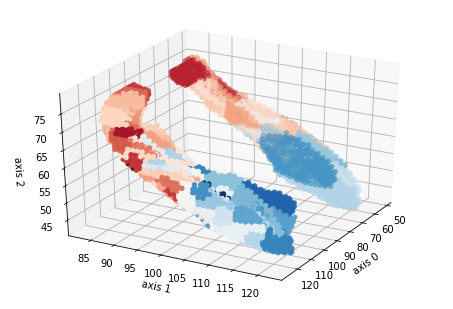

In [87]:
plt.close()
label_locations = [surf_vox['x'].tolist(),
                   surf_vox['y'].tolist(),
                   surf_vox['z'].tolist()]
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(label_locations[0], label_locations[1], label_locations[2], c = rend_hipp_p3[label_locations],
          cmap='RdBu')
# To split into LR, we need to visualize where the LR split is, where front is
for angle in range(0, 30):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
plt.show()


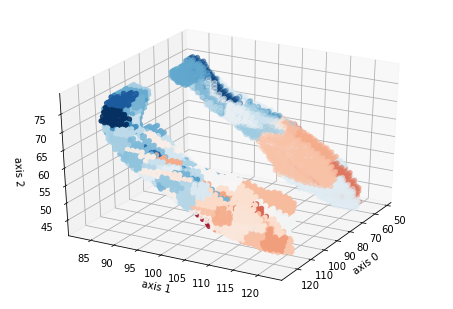

In [92]:
plt.close()
label_locations = [surf_vox['x'].tolist(),
                   surf_vox['y'].tolist(),
                   surf_vox['z'].tolist()]
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(label_locations[0], label_locations[1], label_locations[2], c = rend_hipp_a3[label_locations],
          cmap='RdBu')
# To split into LR, we need to visualize where the LR split is, where front is
for angle in range(0, 30):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
plt.show()


In [93]:
import plotly

In [100]:
temp_trace = plotly.graph_objs.Scatter3d(x = surf_vox['x'].tolist(),
                                        y = surf_vox['y'].tolist(),
                                        z = surf_vox['z'].tolist(),
                                        name = 'hipp',
                                        mode = 'markers',
                                        marker = {'size': 2, 
                                                  'color': rend_hipp_a3[label_locations].tolist(), 
                                                  'colorscale':'RdBu'}
                                        )


layout = plotly.graph_objs.Layout(margin = dict(l=0,r=0,b=0,t=0))

fig = plotly.graph_objs.Figure(data=[temp_trace], layout=layout)
plotly.offline.plot(fig, filename='test.html')


'file:///home/users/jvogel/git/hack_projects/test.html'

In [103]:
rend_hipp_p[rend_hipp_p!=0].shape

(11263,)

In [101]:
label_locations = np.where(hipp == 1)
#label_locations1 = np.where(ap_axis.get_data() > 0)
fig = plt.figure()
# ax = Axes3D(fig)
# ax.scatter(label_locations[0], label_locations[1], label_locations[2], c = rend_hipp_p[label_locations],
#           cmap='RdBu')
# # To split into LR, we need to visualize where the LR split is, where front is
# for angle in range(0, 30):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)

# ax.set_xlabel('axis 0')
# ax.set_ylabel('axis 1')
# ax.set_zlabel('axis 2')
# plt.show()


In [104]:
temp_trace = plotly.graph_objs.Scatter3d(x = label_locations[0],
                                        y =  label_locations[1],
                                        z =  label_locations[2],
                                        name = 'hipp',
                                        mode = 'markers',
                                        marker = {'size': 2, 
                                                  'color': rend_hipp_a[label_locations].tolist(), 
                                                  'colorscale':'RdBu'}
                                        )


layout = plotly.graph_objs.Layout(margin = dict(l=0,r=0,b=0,t=0))

fig = plotly.graph_objs.Figure(data=[temp_trace], layout=layout)
plotly.offline.plot(fig, filename='test.html')


'file:///home/users/jvogel/git/hack_projects/test.html'

In [110]:
xp.shape

(58692, 170)

In [111]:
gdf.structure_name.unique()

array(['claustrum, left', 'nucleus accumbens, left',
       'nucleus accumbens, right', 'substantia innominata, right',
       'claustrum, right', 'globus pallidus, external segment, right',
       'lateral nucleus, right',
       'amygdalohippocampal transition zone, right',
       'basolateral nucleus, right', 'basomedial nucleus, right',
       'substantia innominata, left', 'septal nuclei, left',
       'septal nuclei, right', 'globus pallidus, external segment, left',
       'CA1 field, right', 'CA2 field, right', 'CA3 field, right',
       'CA4 field, right', 'dentate gyrus, right',
       'body of caudate nucleus, right', 'subiculum, left',
       'CA1 field, left', 'CA2 field, left', 'CA3 field, left',
       'CA4 field, left', 'dentate gyrus, left',
       'body of caudate nucleus, left', 'putamen, right',
       'inferior frontal gyrus, opercular part, right',
       'posterior orbital gyrus, right',
       'temporal pole, right, superior aspect',
       'precentral gyrus, le